# Notes nn - Predictors of recorded DS live births

- More boosting rounds


## Preparation


In [1]:
import joblib, optuna, os, shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from lightgbm import early_stopping, log_evaluation
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    brier_score_loss,
    log_loss,
)
from sklearn.model_selection import train_test_split

import repl_utils, stats_utils, data_utils, ml_utils, plot_utils
from variables import Variables as vars

pd.options.mode.copy_on_write = True

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = 47
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

N_CORES = joblib.cpu_count(only_physical_cores=True)

START_TIME = datetime.now()

OUTPUT_DIR = f"output/0010-predictors-10/{START_TIME:%Y%m%d-%H%M%S}"

os.makedirs(OUTPUT_DIR, exist_ok=True)

repl_utils.print_environment_info()

print(f"\n--------------------\nOutput directory: {OUTPUT_DIR}\n--------------------\n")

-------------------- Environment Information --------------------
date: 2026-01-02T20:11:04.913771
platform: Windows-11-10.0.26220-SP0
platform_version: 10.0.26220
cpu: Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
cores: 32
physical_cores: 24
ram: 127 GB
ram_available: 92 GB
cuda: True
cuda_device_count: 1
cuda_device_0: NVIDIA GeForce RTX 4070 Ti SUPER
python: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:10:00) [MSC v.1944 64 bit (AMD64)]
numpy: 2.3.5
pandas: 2.3.3
scipy: 1.16.3
sklearn: 1.8.0
lightgbm: 4.6.0
pytorch: 2.9.1
pymc: 5.27.0
pytensor: 2.36.1
arviz: 0.23.0

--------------------
Output directory: output/0010-predictors-10/20260102-201104
--------------------



### Options


In [2]:
START_YEAR = 2016
END_YEAR = 2024
# LightGBM threads
NUM_THREADS = N_CORES - 2
# Splitting data for training, validation and calibration
TRAINING_SPLIT = 0.75
VALIDATION_SPLIT = 0.25
# CALIBRATION_SPLIT = 1 - TRAINING_SPLIT - VALIDATION_SPLIT
#
NUM_BOOST_ROUND = 75000
EARLY_STOPPING_ROUNDS = 250
# True to search for hyperparameters
SELECT_HYPERPARAMETERS = True
#
OPTIMIZE_TRIALS = 250

SAVE_PLOTS = True

### Load data


In [3]:
df = data_utils.load_predictors_data(
    from_year=START_YEAR, to_year=END_YEAR, include_unknown=True
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Define initial feature set


In [4]:
numeric = [
    vars.YEAR,
    vars.DBWT,
    # vars.PWGT_R,
    vars.WTGAIN,
    vars.BMI,
    vars.MAGE_C,
    vars.FAGECOMB,
]

categorical = [
    # vars.DOB_MM,
    # vars.DOB_WK,
    # "dob_tt_pm",
    vars.BFACIL3,
    vars.SEX,
    vars.PRECARE,
    vars.GESTREC10,
    vars.RF_PDIAB,
    vars.RF_GDIAB,
    vars.RF_PHYPE,
    vars.RF_GHYPE,
    vars.RF_EHYPE,
    vars.RF_PPTERM,
    vars.RF_INFTR,
    vars.RF_FEDRG,
    vars.RF_ARTEC,
    # vars.NO_RISKS,
    vars.LD_INDL,
    vars.LD_AUGM,
    vars.ME_PRES,
    vars.DMETH_REC,
    vars.APGAR5,
    vars.APGAR10,
    vars.AB_AVEN1,
    vars.AB_AVEN6,
    vars.AB_NICU,
    vars.AB_SURF,
    vars.AB_ANTI,
    vars.AB_SEIZ,
    # vars.NO_ABNORM,
    vars.CA_ANEN,
    vars.CA_MNSB,
    vars.CA_CCHD,
    vars.CA_CDH,
    vars.CA_OMPH,
    vars.CA_GAST,
    vars.CA_LIMB,
    vars.CA_CLEFT,
    vars.CA_CLPAL,
    vars.CA_HYPO,
    vars.CA_DISOR,
    # vars.NO_CONGEN,
    vars.MEDUC,
    vars.MRACEHISP,
    vars.FEDUC,
    vars.FRACEHISP,
    vars.PAY_REC,
    vars.WIC,
]

features = categorical + numeric

X = df[features]
y = df["ca_down_c_p_n"].replace({pd.NA: 0, np.nan: 0}).astype(np.int32)

X[categorical] = X[categorical].astype("category")

### Split training, validation and calibration data


In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=(1-TRAINING_SPLIT), stratify=y, random_state=RANDOM_SEED
)

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

In [6]:
neg_count_train = y_train[y_train == 0].count()
pos_count_train = y_train[y_train == 1].count()
# scale_pos_weight = neg_count_train / pos_count_train

neg_count_valid = y_valid[y_valid == 0].count()
pos_count_valid = y_valid[y_valid == 1].count()

print(
    f"Training set: {neg_count_train} negatives, {pos_count_train} positives, probability positive {pos_count_train / neg_count_train:.8f}"
)
print(
    f"Validation set: {neg_count_valid} negatives, {pos_count_valid} positives, probability positive {pos_count_valid / neg_count_valid:.8f}"
)

Training set: 25178564 negatives, 13357 positives, probability positive 0.00053049
Validation set: 8392855 negatives, 4452 positives, probability positive 0.00053045


In [7]:
base_params = {
    "objective": "binary",
    "metric": ["average_precision", "binary_logloss"],
    "boosting_type": "gbdt",
    "max_bin": 255,  # GPU 63/127; CPU 255
    # for now, we do not scale for better interpretability of outputs
    "scale_pos_weight": 1,
    "force_col_wise": True,
    "seed": RANDOM_SEED,
    "num_threads": NUM_THREADS,
    "verbosity": 1,
}

last_best_params = {
    "learning_rate": 0.009461164726049449,
    "num_leaves": 180,
    "min_data_in_leaf": 756,
    "min_gain_to_split": 0.9285634625013361,
    "feature_fraction": 0.9239582799934513,
    "bagging_fraction": 0.9185684081749333,
    "bagging_freq": 2,
    "lambda_l1": 0.0005836073944757167,
    "lambda_l2": 0.6142323696066677
}

## Hyperparameter tuning


In [8]:
def objective(trial):
    trial_params = {
        # required to change min_data_in_leaf across trials without rebuilding the Dataset
        "feature_pre_filter": False,
        # Speed / stability
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.75, log=True),
        # Tree complexity
        "num_leaves": trial.suggest_int("num_leaves", 32, 512, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 10000, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),
        # Sampling
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        # Regularization
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    # Merge: base_params always present; trial_params override if same key exists
    params = {**base_params, **trial_params}

    pruning_cb = optuna.integration.LightGBMPruningCallback(trial, "average_precision")

    gbm = lgb.train(
        params,
        train_data,
        num_boost_round=NUM_BOOST_ROUND,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
            lgb.log_evaluation(period=10),
            pruning_cb,
        ],
    )

    # Best score on validation
    return gbm.best_score["valid_0"]["average_precision"]


if SELECT_HYPERPARAMETERS:
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(),
    )

    study.optimize(objective, n_trials=OPTIMIZE_TRIALS)

    print(study.best_params, study.best_value)

    best = study.best_params
else:
    best = last_best_params

# Merge (best overrides base if there are collisions)
params = {**base_params, **best}
params["feature_pre_filter"] = True  # reset to default for final training

print("Parameters for training:")
for k, v in params.items():
    print(f'  "{k}": {v}')

[I 2026-01-02 20:11:47,329] A new study created in memory with name: no-name-1d5be7e1-e9c0-4bf7-ba0e-c46780c75add


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0246887	valid_0's binary_logloss: 0.00421224
[20]	valid_0's average_precision: 0.0259058	valid_0's binary_logloss: 0.00408404
[30]	valid_0's average_precision: 0.026719	valid_0's binary_logloss: 0.00400131
[40]	valid_0's average_precision: 0.0271244	valid_0's binary_logloss: 0.00393709
[50]	valid_0's average_precision: 0.0275577	valid_0's binary_logloss: 0.00388827
[60]	valid_0's average_precision: 0.0277912	valid_0's binary_logloss: 0.00384973
[70]	valid_0's average_precision: 0.0280501	valid_0's binary_logloss: 0.00381784
[80]	valid_0's average_precision: 0

[I 2026-01-02 20:20:30,026] Trial 0 finished with value: 0.029565070050200527 and parameters: {'learning_rate': 0.008641478378852931, 'num_leaves': 141, 'min_data_in_leaf': 3516, 'min_gain_to_split': 0.22135694253653349, 'feature_fraction': 0.7835897030789775, 'bagging_fraction': 0.7101320802632286, 'bagging_freq': 6, 'lambda_l1': 5.74593000965528e-07, 'lambda_l2': 1.3864355921278165e-06}. Best is trial 0 with value: 0.029565070050200527.


Early stopping, best iteration is:
[263]	valid_0's average_precision: 0.0295651	valid_0's binary_logloss: 0.00362727
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.00461357	valid_0's binary_logloss: 0.00849205
[20]	valid_0's average_precision: 0.0062613	valid_0's binary_logloss: 0.00671035
[30]	valid_0's average_precision: 0.00371247	valid_0's binary_logloss: 0.0073646
[40]	valid_0's average_precision: 0.00282171	valid_0's binary_logloss: 0.0101979
[50]	valid_0's average_precision: 0.00313189	valid_0's binary_logloss: 0.0166169
[60]	valid_0's average_precision: 0.00277252	valid_0's binary_logloss: 0.05640

[I 2026-01-02 20:24:37,262] Trial 1 finished with value: 0.021178230070174463 and parameters: {'learning_rate': 0.32608699813799, 'num_leaves': 262, 'min_data_in_leaf': 1692, 'min_gain_to_split': 0.5265585938448176, 'feature_fraction': 0.9289862615526294, 'bagging_fraction': 0.7448364908346381, 'bagging_freq': 8, 'lambda_l1': 0.0032092120771499404, 'lambda_l2': 0.0006526368053832705}. Best is trial 0 with value: 0.029565070050200527.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.0211782	valid_0's binary_logloss: 0.041453
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.00381684	valid_0's binary_logloss: 0.0117831
[20]	valid_0's average_precision: 0.00377644	valid_0's binary_logloss: 0.0113955
[30]	valid_0's average_precision: 0.00284131	valid_0's binary_logloss: 0.0110076
[40]	valid_0's average_precision: 0.0021788	valid_0's binary_logloss: 0.0267131
[50]	valid_0's average_precision: 0.00210254	valid_0's binary_logloss: 0.022179
[60]	valid_0's average_precision: 0.00256999	valid_0's binary_logloss: 0.0119095
[70]

[I 2026-01-02 20:27:27,426] Trial 2 finished with value: 0.012379355993307915 and parameters: {'learning_rate': 0.7465353159570262, 'num_leaves': 32, 'min_data_in_leaf': 5377, 'min_gain_to_split': 0.442440395217674, 'feature_fraction': 0.8763780555085867, 'bagging_fraction': 0.6308547258686555, 'bagging_freq': 1, 'lambda_l1': 5.189729853974564, 'lambda_l2': 4.637650904462421e-08}. Best is trial 0 with value: 0.029565070050200527.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.0123794	valid_0's binary_logloss: 0.120908
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0251528	valid_0's binary_logloss: 0.00407616
[20]	valid_0's average_precision: 0.0263182	valid_0's binary_logloss: 0.00393931
[30]	valid_0's average_precision: 0.0271431	valid_0's binary_logloss: 0.00385405
[40]	valid_0's average_precision: 0.0277191	valid_0's binary_logloss: 0.00379343
[50]	valid_0's average_precision: 0.028234	valid_0's binary_logloss: 0.00375318
[60]	valid_0's average_precision: 0.0284912	valid_0's binary_logloss: 0.00372164
[70

[I 2026-01-02 20:35:12,765] Trial 3 finished with value: 0.029595129848803536 and parameters: {'learning_rate': 0.018795087657585283, 'num_leaves': 149, 'min_data_in_leaf': 1991, 'min_gain_to_split': 0.9979050608638321, 'feature_fraction': 0.6442280442767695, 'bagging_fraction': 0.8015998883755472, 'bagging_freq': 3, 'lambda_l1': 1.217017116757983e-05, 'lambda_l2': 1.0585125573855962e-05}. Best is trial 3 with value: 0.029595129848803536.


Early stopping, best iteration is:
[208]	valid_0's average_precision: 0.0295951	valid_0's binary_logloss: 0.0036128
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 20:35:15,286] Trial 4 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0251014	valid_0's binary_logloss: 0.00415505
[20]	valid_0's average_precision: 0.0262965	valid_0's binary_logloss: 0.0040254
[30]	valid_0's average_precision: 0.0271258	valid_0's binary_logloss: 0.00394099
[40]	valid_0's average_precision: 0.0275839	valid_0's binary_logloss: 0.00387433
[50]	valid_0's average_precision: 0.0280219	valid_0's binary_logloss: 0.00383023
[60]	valid_0's average_precision: 0.0283189	valid_0's binary_logloss: 0.00379488
[70]	valid_0's average_precision: 0.0286325	valid_0's binary_logloss: 0.00376591
[80]	valid_0's average_precision: 0

[I 2026-01-02 20:51:50,486] Trial 5 finished with value: 0.030917392734066133 and parameters: {'learning_rate': 0.013217301365482706, 'num_leaves': 34, 'min_data_in_leaf': 1242, 'min_gain_to_split': 0.25262398444469236, 'feature_fraction': 0.6993116814297657, 'bagging_fraction': 0.8665758899550575, 'bagging_freq': 10, 'lambda_l1': 3.908415517288257e-07, 'lambda_l2': 0.07742968702912606}. Best is trial 5 with value: 0.030917392734066133.


Early stopping, best iteration is:
[944]	valid_0's average_precision: 0.0309174	valid_0's binary_logloss: 0.00359857
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0048489	valid_0's binary_logloss: 0.00694847
[20]	valid_0's average_precision: 0.00419761	valid_0's binary_logloss: 0.00723081
[30]	valid_0's average_precision: 0.00350535	valid_0's binary_logloss: 0.00872522
[40]	valid_0's average_precision: 0.0029785	valid_0's binary_logloss: 0.0228779
[50]	valid_0's average_precision: 0.0030111	valid_0's binary_logloss: 0.0361694
[60]	valid_0's average_precision: 0.00142464	valid_0's binary_logloss: 0.518571

[I 2026-01-02 20:53:08,983] Trial 6 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 20:53:11,523] Trial 7 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 20:53:14,007] Trial 8 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 20:53:16,900] Trial 9 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 20:53:19,665] Trial 10 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 20:53:23,251] Trial 11 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0245082	valid_0's binary_logloss: 0.00431162
[20]	valid_0's average_precision: 0.0267177	valid_0's binary_logloss: 0.00419702
[30]	valid_0's average_precision: 0.0272071	valid_0's binary_logloss: 0.00411969
[40]	valid_0's average_precision: 0.0274807	valid_0's binary_logloss: 0.00405604
[50]	valid_0's average_precision: 0.027781	valid_0's binary_logloss: 0.00400698
[60]	valid_0's average_precision: 0.0281576	valid_0's binary_logloss: 0.00396547
[70]	valid_0's average_precision: 0.0282856	valid_0's binary_logloss: 0.00393226
[80]	valid_0's average_precision: 0

[I 2026-01-02 21:15:36,468] Trial 12 finished with value: 0.030842481525492172 and parameters: {'learning_rate': 0.005854428838877328, 'num_leaves': 94, 'min_data_in_leaf': 1128, 'min_gain_to_split': 0.16419078150288835, 'feature_fraction': 0.6037594680395485, 'bagging_fraction': 0.8283583748389344, 'bagging_freq': 4, 'lambda_l1': 1.363535914065671e-08, 'lambda_l2': 0.02516861285194258}. Best is trial 5 with value: 0.030917392734066133.


Early stopping, best iteration is:
[1103]	valid_0's average_precision: 0.0308425	valid_0's binary_logloss: 0.00359714
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0257701	valid_0's binary_logloss: 0.00430012
[20]	valid_0's average_precision: 0.0269701	valid_0's binary_logloss: 0.00419279
[30]	valid_0's average_precision: 0.0273436	valid_0's binary_logloss: 0.00411818
[40]	valid_0's average_precision: 0.0277234	valid_0's binary_logloss: 0.00405694
[50]	valid_0's average_precision: 0.0282236	valid_0's binary_logloss: 0.00401179
[60]	valid_0's average_precision: 0.0284504	valid_0's binary_logloss: 0.003972

[I 2026-01-02 21:16:43,408] Trial 13 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:16:47,101] Trial 14 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:16:50,718] Trial 15 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:16:59,202] Trial 16 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:17:07,545] Trial 17 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:17:09,873] Trial 18 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0260406	valid_0's binary_logloss: 0.00421879
[20]	valid_0's average_precision: 0.0270836	valid_0's binary_logloss: 0.00409603
[30]	valid_0's average_precision: 0.0275349	valid_0's binary_logloss: 0.00401624
[40]	valid_0's average_precision: 0.0279949	valid_0's binary_logloss: 0.00395194
[50]	valid_0's average_precision: 0.0283328	valid_0's binary_logloss: 0.00390372
[60]	valid_0's average_precision: 0.028537	valid_0's binary_logloss: 0.00386497
[70]	valid_0's average_precision: 0.0287336	valid_0's binary_logloss: 0.00383329
[80]	valid_0's average_precision: 0

[I 2026-01-02 21:20:54,247] Trial 19 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:20:56,522] Trial 20 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:21:00,591] Trial 21 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0246314	valid_0's binary_logloss: 0.0042205
[20]	valid_0's average_precision: 0.0263336	valid_0's binary_logloss: 0.00408897


[I 2026-01-02 21:21:28,216] Trial 22 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:21:30,458] Trial 23 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:21:39,767] Trial 24 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0241225	valid_0's binary_logloss: 0.00400227
[20]	valid_0's average_precision: 0.0258175	valid_0's binary_logloss: 0.00386752
[30]	valid_0's average_precision: 0.026565	valid_0's binary_logloss: 0.00379335
[40]	valid_0's average_precision: 0.0270908	valid_0's binary_logloss: 0.00374161
[50]	valid_0's average_precision: 0.0274355	valid_0's binary_logloss: 0.00370987
[60]	valid_0's average_precision: 0.0278118	valid_0's binary_logloss: 0.00368608
[70]	valid_0's average_precision: 0.0280501	valid_0's binary_logloss: 0.00366986
[80]	valid_0's average_precision: 0

[I 2026-01-02 21:31:14,723] Trial 25 finished with value: 0.029525479597109577 and parameters: {'learning_rate': 0.026016782195200507, 'num_leaves': 48, 'min_data_in_leaf': 1418, 'min_gain_to_split': 0.6030781405543442, 'feature_fraction': 0.764932845306409, 'bagging_fraction': 0.7985940908506914, 'bagging_freq': 2, 'lambda_l1': 1.0789600099127825e-06, 'lambda_l2': 0.11239565784489822}. Best is trial 5 with value: 0.030917392734066133.


Early stopping, best iteration is:
[408]	valid_0's average_precision: 0.0295255	valid_0's binary_logloss: 0.00361094
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:31:18,570] Trial 26 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:31:20,914] Trial 27 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:31:25,741] Trial 28 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:31:33,801] Trial 29 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:31:36,144] Trial 30 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:31:38,512] Trial 31 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:31:41,085] Trial 32 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0223742	valid_0's binary_logloss: 0.00424027
[20]	valid_0's average_precision: 0.0248654	valid_0's binary_logloss: 0.00411214
[30]	valid_0's average_precision: 0.0256009	valid_0's binary_logloss: 0.00403037
[40]	valid_0's average_precision: 0.0261722	valid_0's binary_logloss: 0.00396623
[50]	valid_0's average_precision: 0.0266661	valid_0's binary_logloss: 0.00391813
[60]	valid_0's average_precision: 0.026996	valid_0's binary_logloss: 0.00387943
[70]	valid_0's average_precision: 0.0274088	valid_0's binary_logloss: 0.00384616
[80]	valid_0's average_precision: 0

[I 2026-01-02 21:46:29,792] Trial 33 finished with value: 0.029581158561090726 and parameters: {'learning_rate': 0.007471975135712965, 'num_leaves': 158, 'min_data_in_leaf': 6557, 'min_gain_to_split': 0.20161813721460645, 'feature_fraction': 0.8407106775583415, 'bagging_fraction': 0.907187317929381, 'bagging_freq': 1, 'lambda_l1': 7.323497319514612e-08, 'lambda_l2': 1.377654467396145e-05}. Best is trial 5 with value: 0.030917392734066133.


Early stopping, best iteration is:
[524]	valid_0's average_precision: 0.0295812	valid_0's binary_logloss: 0.00360528
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2026-01-02 21:46:32,273] Trial 34 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:46:36,912] Trial 35 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:46:39,101] Trial 36 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:46:44,191] Trial 37 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0262296	valid_0's binary_logloss: 0.00415812
[20]	valid_0's average_precision: 0.0270946	valid_0's binary_logloss: 0.00402891
[30]	valid_0's average_precision: 0.027684	valid_0's binary_logloss: 0.00394421
[40]	valid_0's average_precision: 0.0280636	valid_0's binary_logloss: 0.0038807
[50]	valid_0's average_precision: 0.0283727	valid_0's binary_logloss: 0.00383464
[60]	valid_0's average_precision: 0.0286551	valid_0's binary_logloss: 0.00379909
[70]	valid_0's average_precision: 0.0288154	valid_0's binary_logloss: 0.00377007
[80]	valid_0's average_precision: 0.

[I 2026-01-02 21:50:45,502] Trial 38 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:50:48,465] Trial 39 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:50:57,054] Trial 40 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0242995	valid_0's binary_logloss: 0.00422127
[20]	valid_0's average_precision: 0.0256647	valid_0's binary_logloss: 0.00409585
[30]	valid_0's average_precision: 0.0262245	valid_0's binary_logloss: 0.00401384
[40]	valid_0's average_precision: 0.0268613	valid_0's binary_logloss: 0.00394973
[50]	valid_0's average_precision: 0.027337	valid_0's binary_logloss: 0.00390273
[60]	valid_0's average_precision: 0.0277803	valid_0's binary_logloss: 0.0038647
[70]	valid_0's average_precision: 0.0279981	valid_0's binary_logloss: 0.00383231
[80]	valid_0's average_precision: 0.

[I 2026-01-02 21:52:08,094] Trial 41 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0046258	valid_0's binary_logloss: 0.00558226
[20]	valid_0's average_precision: 0.00479746	valid_0's binary_logloss: 0.00554723
[30]	valid_0's average_precision: 0.00509666	valid_0's binary_logloss: 0.00566777
[40]	valid_0's average_precision: 0.00484187	valid_0's binary_logloss: 0.00565735
[50]	valid_0's average_precision: 0.00397479	valid_0's binary_logloss: 0.00604119
[60]	valid_0's average_precision: 0.00313261	valid_0's binary_logloss: 0.0120734
[70]	valid_0's average_precision: 0.0024889	valid_0's binary_logloss: 0.143764
[80]	valid_0's average_precision

[I 2026-01-02 21:55:41,152] Trial 42 finished with value: 0.013151506913803426 and parameters: {'learning_rate': 0.40951624292649214, 'num_leaves': 143, 'min_data_in_leaf': 3139, 'min_gain_to_split': 0.40514454482485607, 'feature_fraction': 0.7804354465251079, 'bagging_fraction': 0.6869394685748117, 'bagging_freq': 5, 'lambda_l1': 0.1617201474989069, 'lambda_l2': 2.1948719948227617e-07}. Best is trial 5 with value: 0.030917392734066133.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.0131515	valid_0's binary_logloss: 0.042827
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0270281	valid_0's binary_logloss: 0.0041101
[20]	valid_0's average_precision: 0.0276171	valid_0's binary_logloss: 0.00397848
[30]	valid_0's average_precision: 0.0279465	valid_0's binary_logloss: 0.00389923
[40]	valid_0's average_precision: 0.0285509	valid_0's binary_logloss: 0.00383635
[50]	valid_0's average_precision: 0.0288899	valid_0's binary_logloss: 0.00379364
[60]	valid_0's average_precision: 0.0289193	valid_0's binary_logloss: 0.00376044
[70

[I 2026-01-02 21:59:43,574] Trial 43 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:59:45,859] Trial 44 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 21:59:49,373] Trial 45 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0245058	valid_0's binary_logloss: 0.00422496
[20]	valid_0's average_precision: 0.0253563	valid_0's binary_logloss: 0.0040915
[30]	valid_0's average_precision: 0.0262559	valid_0's binary_logloss: 0.00400394
[40]	valid_0's average_precision: 0.0265883	valid_0's binary_logloss: 0.00393585
[50]	valid_0's average_precision: 0.0270421	valid_0's binary_logloss: 0.00388505
[60]	valid_0's average_precision: 0.0274296	valid_0's binary_logloss: 0.00384483
[70]	valid_0's average_precision: 0.0279144	valid_0's binary_logloss: 0.00381105
[80]	valid_0's average_precision: 0

[I 2026-01-02 22:15:03,409] Trial 46 finished with value: 0.030010811690184987 and parameters: {'learning_rate': 0.009248919721107784, 'num_leaves': 236, 'min_data_in_leaf': 4616, 'min_gain_to_split': 0.35330524922593537, 'feature_fraction': 0.8320721277631975, 'bagging_fraction': 0.9208022525561409, 'bagging_freq': 4, 'lambda_l1': 0.47628711607960234, 'lambda_l2': 2.35535049705801}. Best is trial 5 with value: 0.030917392734066133.


Early stopping, best iteration is:
[447]	valid_0's average_precision: 0.0300108	valid_0's binary_logloss: 0.00360192
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:15:06,279] Trial 47 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0236465	valid_0's binary_logloss: 0.00416332
[20]	valid_0's average_precision: 0.0250706	valid_0's binary_logloss: 0.00402489


[I 2026-01-02 22:15:39,577] Trial 48 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:15:42,871] Trial 49 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0242733	valid_0's binary_logloss: 0.00429093
[20]	valid_0's average_precision: 0.0267704	valid_0's binary_logloss: 0.00417162
[30]	valid_0's average_precision: 0.0273537	valid_0's binary_logloss: 0.00409212
[40]	valid_0's average_precision: 0.027822	valid_0's binary_logloss: 0.00402961
[50]	valid_0's average_precision: 0.028111	valid_0's binary_logloss: 0.00398277
[60]	valid_0's average_precision: 0.0283892	valid_0's binary_logloss: 0.00394192
[70]	valid_0's average_precision: 0.028666	valid_0's binary_logloss: 0.00390981
[80]	valid_0's average_precision: 0.0

[I 2026-01-02 22:37:41,995] Trial 50 finished with value: 0.03126292607807213 and parameters: {'learning_rate': 0.006732265937008822, 'num_leaves': 36, 'min_data_in_leaf': 687, 'min_gain_to_split': 0.7477582714720323, 'feature_fraction': 0.6556482987026745, 'bagging_fraction': 0.8792137312281266, 'bagging_freq': 2, 'lambda_l1': 0.09384647279858219, 'lambda_l2': 0.13588212007607534}. Best is trial 50 with value: 0.03126292607807213.


Early stopping, best iteration is:
[1139]	valid_0's average_precision: 0.0312629	valid_0's binary_logloss: 0.00359999
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:37:45,437] Trial 51 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:37:47,737] Trial 52 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:37:54,579] Trial 53 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:37:57,009] Trial 54 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:38:05,102] Trial 55 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:38:07,126] Trial 56 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:38:10,168] Trial 57 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:38:12,607] Trial 58 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:38:17,875] Trial 59 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0254418	valid_0's binary_logloss: 0.00410277
[20]	valid_0's average_precision: 0.0264292	valid_0's binary_logloss: 0.003972


[I 2026-01-02 22:38:38,103] Trial 60 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:38:40,565] Trial 61 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:38:43,276] Trial 62 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:38:51,259] Trial 63 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0247036	valid_0's binary_logloss: 0.00424507
[20]	valid_0's average_precision: 0.0256483	valid_0's binary_logloss: 0.00412338


[I 2026-01-02 22:39:14,546] Trial 64 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:39:18,573] Trial 65 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:39:21,058] Trial 66 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:39:24,812] Trial 67 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:39:34,939] Trial 68 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:39:39,742] Trial 69 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:39:42,784] Trial 70 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:39:44,882] Trial 71 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:39:48,392] Trial 72 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0271832	valid_0's binary_logloss: 0.00416802
[20]	valid_0's average_precision: 0.0277549	valid_0's binary_logloss: 0.00404017
[30]	valid_0's average_precision: 0.0283451	valid_0's binary_logloss: 0.00396019
[40]	valid_0's average_precision: 0.0288203	valid_0's binary_logloss: 0.00389638
[50]	valid_0's average_precision: 0.0289958	valid_0's binary_logloss: 0.00385089
[60]	valid_0's average_precision: 0.0291352	valid_0's binary_logloss: 0.00381494
[70]	valid_0's average_precision: 0.0293838	valid_0's binary_logloss: 0.00378484
[80]	valid_0's average_precision: 

[I 2026-01-02 22:43:34,234] Trial 73 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0256283	valid_0's binary_logloss: 0.00401062
[20]	valid_0's average_precision: 0.0261672	valid_0's binary_logloss: 0.00387646
[30]	valid_0's average_precision: 0.026407	valid_0's binary_logloss: 0.00380122
[40]	valid_0's average_precision: 0.0268273	valid_0's binary_logloss: 0.00374972
[50]	valid_0's average_precision: 0.0268612	valid_0's binary_logloss: 0.00371689
[60]	valid_0's average_precision: 0.0269333	valid_0's binary_logloss: 0.00369339
[70]	valid_0's average_precision: 0.027148	valid_0's binary_logloss: 0.00367655
[80]	valid_0's average_precision: 0.

[I 2026-01-02 22:47:13,492] Trial 74 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:47:16,807] Trial 75 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0254153	valid_0's binary_logloss: 0.00408011
[20]	valid_0's average_precision: 0.0265817	valid_0's binary_logloss: 0.0039489
[30]	valid_0's average_precision: 0.0271875	valid_0's binary_logloss: 0.00386907
[40]	valid_0's average_precision: 0.0278113	valid_0's binary_logloss: 0.00381033
[50]	valid_0's average_precision: 0.0281552	valid_0's binary_logloss: 0.00376908
[60]	valid_0's average_precision: 0.0284093	valid_0's binary_logloss: 0.00373823
[70]	valid_0's average_precision: 0.0287413	valid_0's binary_logloss: 0.0037148
[80]	valid_0's average_precision: 0.

[I 2026-01-02 22:48:18,578] Trial 76 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:48:21,919] Trial 77 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:48:24,444] Trial 78 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 22:48:27,034] Trial 79 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0269431	valid_0's binary_logloss: 0.00422686
[20]	valid_0's average_precision: 0.0279636	valid_0's binary_logloss: 0.00410695
[30]	valid_0's average_precision: 0.028347	valid_0's binary_logloss: 0.00402822
[40]	valid_0's average_precision: 0.0286403	valid_0's binary_logloss: 0.00396513
[50]	valid_0's average_precision: 0.0288636	valid_0's binary_logloss: 0.00391741
[60]	valid_0's average_precision: 0.0290687	valid_0's binary_logloss: 0.00387884
[70]	valid_0's average_precision: 0.0293004	valid_0's binary_logloss: 0.00384661
[80]	valid_0's average_precision: 0

[I 2026-01-02 22:59:25,818] Trial 80 finished with value: 0.030287703458227292 and parameters: {'learning_rate': 0.00733457688279569, 'num_leaves': 152, 'min_data_in_leaf': 731, 'min_gain_to_split': 0.29298921878295625, 'feature_fraction': 0.794918163354179, 'bagging_fraction': 0.9039945047184659, 'bagging_freq': 2, 'lambda_l1': 2.2952645650128466e-07, 'lambda_l2': 2.073920067654764e-08}. Best is trial 50 with value: 0.03126292607807213.


[590]	valid_0's average_precision: 0.0301823	valid_0's binary_logloss: 0.00360495
Early stopping, best iteration is:
[340]	valid_0's average_precision: 0.0302877	valid_0's binary_logloss: 0.00362109
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0269826	valid_0's binary_logloss: 0.00424155
[20]	valid_0's average_precision: 0.0278001	valid_0's binary_logloss: 0.00412429


[I 2026-01-02 22:59:50,355] Trial 81 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0271994	valid_0's binary_logloss: 0.00426747
[20]	valid_0's average_precision: 0.0276471	valid_0's binary_logloss: 0.00415886


[I 2026-01-02 23:00:11,675] Trial 82 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0268853	valid_0's binary_logloss: 0.00415392
[20]	valid_0's average_precision: 0.0274368	valid_0's binary_logloss: 0.00402581


[I 2026-01-02 23:00:37,167] Trial 83 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0270519	valid_0's binary_logloss: 0.00422208
[20]	valid_0's average_precision: 0.0280258	valid_0's binary_logloss: 0.00410123
[30]	valid_0's average_precision: 0.028514	valid_0's binary_logloss: 0.00402267
[40]	valid_0's average_precision: 0.028926	valid_0's binary_logloss: 0.00395903
[50]	valid_0's average_precision: 0.0292369	valid_0's binary_logloss: 0.00391235
[60]	valid_0's average_precision: 0.0294073	valid_0's binary_logloss: 0.00387342
[70]	valid_0's average_precision: 0.0296247	valid_0's binary_logloss: 0.00384123
[80]	valid_0's average_precision: 0.

[I 2026-01-02 23:10:49,374] Trial 84 finished with value: 0.030491578040169297 and parameters: {'learning_rate': 0.007603579320850273, 'num_leaves': 156, 'min_data_in_leaf': 653, 'min_gain_to_split': 0.33078638474924893, 'feature_fraction': 0.7688426049166669, 'bagging_fraction': 0.8750105258116498, 'bagging_freq': 1, 'lambda_l1': 1.1345542388665694e-07, 'lambda_l2': 2.4764412269653076e-08}. Best is trial 50 with value: 0.03126292607807213.


Early stopping, best iteration is:
[328]	valid_0's average_precision: 0.0304916	valid_0's binary_logloss: 0.00362206
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0276543	valid_0's binary_logloss: 0.00421119
[20]	valid_0's average_precision: 0.0280796	valid_0's binary_logloss: 0.00409146
[30]	valid_0's average_precision: 0.0284925	valid_0's binary_logloss: 0.00401323
[40]	valid_0's average_precision: 0.0287107	valid_0's binary_logloss: 0.00395078
[50]	valid_0's average_precision: 0.0289072	valid_0's binary_logloss: 0.00390408
[60]	valid_0's average_precision: 0.0291215	valid_0's binary_logloss: 0.0038666

[I 2026-01-02 23:14:57,669] Trial 85 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:14:59,908] Trial 86 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0266082	valid_0's binary_logloss: 0.00422097
[20]	valid_0's average_precision: 0.0273262	valid_0's binary_logloss: 0.00410564
[30]	valid_0's average_precision: 0.0276921	valid_0's binary_logloss: 0.00402703
[40]	valid_0's average_precision: 0.0278929	valid_0's binary_logloss: 0.00396592
[50]	valid_0's average_precision: 0.0281727	valid_0's binary_logloss: 0.00392011
[60]	valid_0's average_precision: 0.0284012	valid_0's binary_logloss: 0.0038825
[70]	valid_0's average_precision: 0.0286344	valid_0's binary_logloss: 0.00385071
[80]	valid_0's average_precision: 0

[I 2026-01-02 23:16:15,862] Trial 87 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0266741	valid_0's binary_logloss: 0.00428506
[20]	valid_0's average_precision: 0.0277629	valid_0's binary_logloss: 0.00417558
[30]	valid_0's average_precision: 0.0283574	valid_0's binary_logloss: 0.00410166
[40]	valid_0's average_precision: 0.0285442	valid_0's binary_logloss: 0.00404139
[50]	valid_0's average_precision: 0.0287565	valid_0's binary_logloss: 0.00399469
[60]	valid_0's average_precision: 0.0289976	valid_0's binary_logloss: 0.00395594
[70]	valid_0's average_precision: 0.0291375	valid_0's binary_logloss: 0.0039232
[80]	valid_0's average_precision: 0

[I 2026-01-02 23:30:00,375] Trial 88 pruned. Trial was pruned at iteration 729.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 250 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2026-01-02 23:30:04,759] Trial 89 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:30:13,147] Trial 90 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:30:16,923] Trial 91 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:30:19,302] Trial 92 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0251374	valid_0's binary_logloss: 0.00418382
[20]	valid_0's average_precision: 0.0262863	valid_0's binary_logloss: 0.00405029
[30]	valid_0's average_precision: 0.0268621	valid_0's binary_logloss: 0.00396396
[40]	valid_0's average_precision: 0.0272911	valid_0's binary_logloss: 0.00389722
[50]	valid_0's average_precision: 0.0276351	valid_0's binary_logloss: 0.00385108
[60]	valid_0's average_precision: 0.0278949	valid_0's binary_logloss: 0.00381305
[70]	valid_0's average_precision: 0.0282239	valid_0's binary_logloss: 0.00378199
[80]	valid_0's average_precision: 

[I 2026-01-02 23:34:35,241] Trial 93 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:34:38,543] Trial 94 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:34:42,548] Trial 95 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 250 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2026-01-02 23:35:12,818] Trial 96 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.024729	valid_0's binary_logloss: 0.00414934
[20]	valid_0's average_precision: 0.0259837	valid_0's binary_logloss: 0.00401677


[I 2026-01-02 23:35:35,091] Trial 97 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:35:37,492] Trial 98 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:35:40,437] Trial 99 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0263978	valid_0's binary_logloss: 0.00423926
[20]	valid_0's average_precision: 0.0270481	valid_0's binary_logloss: 0.00412235


[I 2026-01-02 23:35:58,620] Trial 100 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:36:00,990] Trial 101 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.00202364	valid_0's binary_logloss: 0.0196537
[20]	valid_0's average_precision: 0.00135366	valid_0's binary_logloss: 0.161544


[I 2026-01-02 23:36:30,831] Trial 102 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:36:35,014] Trial 103 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:36:37,548] Trial 104 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0265971	valid_0's binary_logloss: 0.00416071
[20]	valid_0's average_precision: 0.0274266	valid_0's binary_logloss: 0.00403733
[30]	valid_0's average_precision: 0.0278355	valid_0's binary_logloss: 0.00395526
[40]	valid_0's average_precision: 0.0282012	valid_0's binary_logloss: 0.00389327
[50]	valid_0's average_precision: 0.0284417	valid_0's binary_logloss: 0.00384815
[60]	valid_0's average_precision: 0.0286036	valid_0's binary_logloss: 0.00381289
[70]	valid_0's average_precision: 0.0288488	valid_0's binary_logloss: 0.00378349
[80]	valid_0's average_precision: 

[I 2026-01-02 23:40:48,715] Trial 105 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:40:51,489] Trial 106 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:40:53,566] Trial 107 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:40:56,173] Trial 108 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:40:58,681] Trial 109 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0262899	valid_0's binary_logloss: 0.00420758
[20]	valid_0's average_precision: 0.0268272	valid_0's binary_logloss: 0.00408709


[I 2026-01-02 23:41:17,171] Trial 110 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:41:21,724] Trial 111 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:41:25,982] Trial 112 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:41:28,351] Trial 113 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:41:30,638] Trial 114 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.00162671	valid_0's binary_logloss: 0.02927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's average_precision: 0.000404249	valid_0's binary_logloss: 0.0187502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2026-01-02 23:41:53,785] Trial 115 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:41:57,079] Trial 116 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:41:59,265] Trial 117 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:42:02,764] Trial 118 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.00519535	valid_0's binary_logloss: 0.0115859
[20]	valid_0's average_precision: 0.00336001	valid_0's binary_logloss: 0.0231672
[30]	valid_0's average_precision: 0.00339588	valid_0's binary_logloss: 0.0247499
[40]	valid_0's average_precision: 0.00337303	valid_0's binary_logloss: 0.0169996
[50]	valid_0's average_precision: 0.0024866	valid_0's binary_logloss: 0.125677
[60]	valid_0's average_precision: 0.000649098	valid_0's binary_logloss: 0.228156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2026-01-02 23:43:14,921] Trial 119 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:43:18,996] Trial 120 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:43:21,713] Trial 121 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:43:23,332] Trial 122 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:43:25,686] Trial 123 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:43:29,313] Trial 124 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 250 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's average_precision: 0.00363665	valid_0's binary_logloss: 0.006

[I 2026-01-02 23:43:59,873] Trial 125 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0239655	valid_0's binary_logloss: 0.0043199
[20]	valid_0's average_precision: 0.026083	valid_0's binary_logloss: 0.00420644
[30]	valid_0's average_precision: 0.026409	valid_0's binary_logloss: 0.00412975
[40]	valid_0's average_precision: 0.0268274	valid_0's binary_logloss: 0.00406617
[50]	valid_0's average_precision: 0.0272248	valid_0's binary_logloss: 0.00401694
[60]	valid_0's average_precision: 0.0274322	valid_0's binary_logloss: 0.00397533
[70]	valid_0's average_precision: 0.0275337	valid_0's binary_logloss: 0.0039419
[80]	valid_0's average_precision: 0.02

[I 2026-01-02 23:45:27,417] Trial 126 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:45:34,857] Trial 127 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:45:41,662] Trial 128 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:45:44,265] Trial 129 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:45:55,425] Trial 130 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:46:04,390] Trial 131 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:46:07,309] Trial 132 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0273042	valid_0's binary_logloss: 0.00425009
[20]	valid_0's average_precision: 0.0282796	valid_0's binary_logloss: 0.00413485
[30]	valid_0's average_precision: 0.0286281	valid_0's binary_logloss: 0.00405921
[40]	valid_0's average_precision: 0.0287771	valid_0's binary_logloss: 0.00399713
[50]	valid_0's average_precision: 0.0290071	valid_0's binary_logloss: 0.00395093
[60]	valid_0's average_precision: 0.0293272	valid_0's binary_logloss: 0.00391161
[70]	valid_0's average_precision: 0.0294619	valid_0's binary_logloss: 0.00387883
[80]	valid_0's average_precision: 

[I 2026-01-02 23:58:00,807] Trial 133 finished with value: 0.030288903074228234 and parameters: {'learning_rate': 0.006302925787691603, 'num_leaves': 223, 'min_data_in_leaf': 566, 'min_gain_to_split': 0.24209698880145528, 'feature_fraction': 0.7684427037189279, 'bagging_fraction': 0.9217996045139211, 'bagging_freq': 4, 'lambda_l1': 1.4781450661705686e-05, 'lambda_l2': 1.067084130824932e-06}. Best is trial 50 with value: 0.03126292607807213.


Early stopping, best iteration is:
[372]	valid_0's average_precision: 0.0302889	valid_0's binary_logloss: 0.00362459
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0269526	valid_0's binary_logloss: 0.00424155
[20]	valid_0's average_precision: 0.0279601	valid_0's binary_logloss: 0.00412483
[30]	valid_0's average_precision: 0.0283687	valid_0's binary_logloss: 0.00404807
[40]	valid_0's average_precision: 0.0284533	valid_0's binary_logloss: 0.00398517
[50]	valid_0's average_precision: 0.0288475	valid_0's binary_logloss: 0.00393807
[60]	valid_0's average_precision: 0.0290268	valid_0's binary_logloss: 0.0038989

[I 2026-01-02 23:59:20,297] Trial 134 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:59:24,115] Trial 135 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:59:32,080] Trial 136 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2026-01-02 23:59:41,138] Trial 137 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:59:50,061] Trial 138 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-02 23:59:53,866] Trial 139 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0268913	valid_0's binary_logloss: 0.00419727
[20]	valid_0's average_precision: 0.0275359	valid_0's binary_logloss: 0.00407416
[30]	valid_0's average_precision: 0.0279162	valid_0's binary_logloss: 0.00399549
[40]	valid_0's average_precision: 0.0281773	valid_0's binary_logloss: 0.00393245
[50]	valid_0's average_precision: 0.0285182	valid_0's binary_logloss: 0.00388633
[60]	valid_0's average_precision: 0.0287278	valid_0's binary_logloss: 0.00384955
[70]	valid_0's average_precision: 0.0289923	valid_0's binary_logloss: 0.00381847
[80]	valid_0's average_precision: 

[I 2026-01-03 00:11:51,462] Trial 140 pruned. Trial was pruned at iteration 729.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0276378	valid_0's binary_logloss: 0.00419564
[20]	valid_0's average_precision: 0.0280143	valid_0's binary_logloss: 0.00407414
[30]	valid_0's average_precision: 0.0284448	valid_0's binary_logloss: 0.00399564
[40]	valid_0's average_precision: 0.02876	valid_0's binary_logloss: 0.003933
[50]	valid_0's average_precision: 0.029044	valid_0's binary_logloss: 0.00388683
[60]	valid_0's average_precision: 0.0292275	valid_0's binary_logloss: 0.00385021
[70]	valid_0's average_precision: 0.029508	valid_0's binary_logloss: 0.00381905
[80]	valid_0's average_precision: 0.0297

[I 2026-01-03 00:24:48,699] Trial 141 finished with value: 0.031235150215164924 and parameters: {'learning_rate': 0.009011328860653142, 'num_leaves': 45, 'min_data_in_leaf': 587, 'min_gain_to_split': 0.41640673711918913, 'feature_fraction': 0.8417701802060943, 'bagging_fraction': 0.9129536177452806, 'bagging_freq': 3, 'lambda_l1': 7.5920335753066274e-06, 'lambda_l2': 0.01638222770220513}. Best is trial 50 with value: 0.03126292607807213.


Early stopping, best iteration is:
[548]	valid_0's average_precision: 0.0312352	valid_0's binary_logloss: 0.00360587
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:24:55,832] Trial 142 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0268995	valid_0's binary_logloss: 0.00414383
[20]	valid_0's average_precision: 0.0275167	valid_0's binary_logloss: 0.00401592
[30]	valid_0's average_precision: 0.0279607	valid_0's binary_logloss: 0.00393597
[40]	valid_0's average_precision: 0.0283804	valid_0's binary_logloss: 0.00387296
[50]	valid_0's average_precision: 0.0286263	valid_0's binary_logloss: 0.00382848
[60]	valid_0's average_precision: 0.0288586	valid_0's binary_logloss: 0.00379395
[70]	valid_0's average_precision: 0.0290566	valid_0's binary_logloss: 0.00376541
[80]	valid_0's average_precision: 

[I 2026-01-03 00:28:50,175] Trial 143 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:28:57,644] Trial 144 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:29:01,029] Trial 145 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:29:04,562] Trial 146 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:29:06,921] Trial 147 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:29:10,757] Trial 148 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:29:14,831] Trial 149 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:29:21,437] Trial 150 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0270133	valid_0's binary_logloss: 0.00419987
[20]	valid_0's average_precision: 0.0276595	valid_0's binary_logloss: 0.00407696


[I 2026-01-03 00:29:42,433] Trial 151 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.027276	valid_0's binary_logloss: 0.0042204
[20]	valid_0's average_precision: 0.0278045	valid_0's binary_logloss: 0.00410009
[30]	valid_0's average_precision: 0.0281525	valid_0's binary_logloss: 0.00402269
[40]	valid_0's average_precision: 0.0284389	valid_0's binary_logloss: 0.00395959
[50]	valid_0's average_precision: 0.028675	valid_0's binary_logloss: 0.00391365
[60]	valid_0's average_precision: 0.0289234	valid_0's binary_logloss: 0.00387618
[70]	valid_0's average_precision: 0.0291165	valid_0's binary_logloss: 0.00384454
[80]	valid_0's average_precision: 0.0

[I 2026-01-03 00:42:09,214] Trial 152 finished with value: 0.03101721535905487 and parameters: {'learning_rate': 0.00809448809595326, 'num_leaves': 40, 'min_data_in_leaf': 572, 'min_gain_to_split': 0.43433273681446244, 'feature_fraction': 0.8118839296478342, 'bagging_fraction': 0.9179489501417172, 'bagging_freq': 3, 'lambda_l1': 7.032787321621029e-06, 'lambda_l2': 0.01616657226289257}. Best is trial 50 with value: 0.03126292607807213.


Early stopping, best iteration is:
[514]	valid_0's average_precision: 0.0310172	valid_0's binary_logloss: 0.00361106
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:42:16,673] Trial 153 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:42:23,987] Trial 154 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0261871	valid_0's binary_logloss: 0.00422624
[20]	valid_0's average_precision: 0.0269174	valid_0's binary_logloss: 0.00410731
[30]	valid_0's average_precision: 0.0274008	valid_0's binary_logloss: 0.00402922
[40]	valid_0's average_precision: 0.0276781	valid_0's binary_logloss: 0.00396701
[50]	valid_0's average_precision: 0.0279985	valid_0's binary_logloss: 0.00391991
[60]	valid_0's average_precision: 0.0282837	valid_0's binary_logloss: 0.00388171
[70]	valid_0's average_precision: 0.0285026	valid_0's binary_logloss: 0.00385036
[80]	valid_0's average_precision: 

[I 2026-01-03 00:43:25,847] Trial 155 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:43:32,749] Trial 156 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:43:35,318] Trial 157 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:43:37,257] Trial 158 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:43:39,201] Trial 159 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:43:42,999] Trial 160 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0272416	valid_0's binary_logloss: 0.00419758
[20]	valid_0's average_precision: 0.0275668	valid_0's binary_logloss: 0.00407404


[I 2026-01-03 00:44:04,151] Trial 161 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0274708	valid_0's binary_logloss: 0.00422104
[20]	valid_0's average_precision: 0.0280023	valid_0's binary_logloss: 0.00410074
[30]	valid_0's average_precision: 0.0283325	valid_0's binary_logloss: 0.0040235
[40]	valid_0's average_precision: 0.0287043	valid_0's binary_logloss: 0.00396002
[50]	valid_0's average_precision: 0.0289893	valid_0's binary_logloss: 0.00391393
[60]	valid_0's average_precision: 0.0292622	valid_0's binary_logloss: 0.00387631
[70]	valid_0's average_precision: 0.0294645	valid_0's binary_logloss: 0.00384431
[80]	valid_0's average_precision: 0

[I 2026-01-03 00:56:22,429] Trial 162 pruned. Trial was pruned at iteration 729.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:56:26,265] Trial 163 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:56:33,918] Trial 164 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:56:42,210] Trial 165 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:56:51,005] Trial 166 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:56:53,776] Trial 167 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:57:00,202] Trial 168 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:57:03,188] Trial 169 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:57:07,623] Trial 170 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:57:15,072] Trial 171 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 00:57:18,811] Trial 172 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0272066	valid_0's binary_logloss: 0.00418466
[20]	valid_0's average_precision: 0.0278002	valid_0's binary_logloss: 0.00405939
[30]	valid_0's average_precision: 0.0282056	valid_0's binary_logloss: 0.00398011
[40]	valid_0's average_precision: 0.0284849	valid_0's binary_logloss: 0.00391668
[50]	valid_0's average_precision: 0.0287481	valid_0's binary_logloss: 0.00387072
[60]	valid_0's average_precision: 0.028941	valid_0's binary_logloss: 0.00383451
[70]	valid_0's average_precision: 0.0292021	valid_0's binary_logloss: 0.00380392
[80]	valid_0's average_precision: 0

[I 2026-01-03 01:09:24,033] Trial 173 pruned. Trial was pruned at iteration 729.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:09:27,167] Trial 174 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:09:34,358] Trial 175 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:09:36,693] Trial 176 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:09:38,529] Trial 177 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:09:42,520] Trial 178 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:09:52,806] Trial 179 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:09:55,558] Trial 180 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0269403	valid_0's binary_logloss: 0.00417917
[20]	valid_0's average_precision: 0.0276467	valid_0's binary_logloss: 0.0040531
[30]	valid_0's average_precision: 0.0280753	valid_0's binary_logloss: 0.0039734
[40]	valid_0's average_precision: 0.0283023	valid_0's binary_logloss: 0.00391015
[50]	valid_0's average_precision: 0.0285872	valid_0's binary_logloss: 0.00386451
[60]	valid_0's average_precision: 0.0288023	valid_0's binary_logloss: 0.00382827
[70]	valid_0's average_precision: 0.0290585	valid_0's binary_logloss: 0.00379774
[80]	valid_0's average_precision: 0.

[I 2026-01-03 01:11:04,254] Trial 181 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:11:11,796] Trial 182 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:11:15,964] Trial 183 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.027536	valid_0's binary_logloss: 0.00422278
[20]	valid_0's average_precision: 0.0278002	valid_0's binary_logloss: 0.00410464


[I 2026-01-03 01:11:37,040] Trial 184 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:11:40,399] Trial 185 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:11:42,712] Trial 186 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:11:44,823] Trial 187 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:11:47,485] Trial 188 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:11:49,594] Trial 189 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:11:51,872] Trial 190 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0264973	valid_0's binary_logloss: 0.00425874
[20]	valid_0's average_precision: 0.0275221	valid_0's binary_logloss: 0.00414463
[30]	valid_0's average_precision: 0.027997	valid_0's binary_logloss: 0.00406873
[40]	valid_0's average_precision: 0.028153	valid_0's binary_logloss: 0.00400683
[50]	valid_0's average_precision: 0.0284817	valid_0's binary_logloss: 0.00395924
[60]	valid_0's average_precision: 0.0286812	valid_0's binary_logloss: 0.00392052
[70]	valid_0's average_precision: 0.0288704	valid_0's binary_logloss: 0.00388781
[80]	valid_0's average_precision: 0.

[I 2026-01-03 01:13:11,187] Trial 191 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:13:20,038] Trial 192 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:13:27,299] Trial 193 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:13:31,204] Trial 194 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:13:33,290] Trial 195 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:13:36,332] Trial 196 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:13:40,871] Trial 197 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:13:49,609] Trial 198 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0269944	valid_0's binary_logloss: 0.00428196
[20]	valid_0's average_precision: 0.0276564	valid_0's binary_logloss: 0.00417327


[I 2026-01-03 01:14:13,285] Trial 199 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:14:16,030] Trial 200 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0274188	valid_0's binary_logloss: 0.00419025
[20]	valid_0's average_precision: 0.0281636	valid_0's binary_logloss: 0.00406507
[30]	valid_0's average_precision: 0.0287885	valid_0's binary_logloss: 0.00398607
[40]	valid_0's average_precision: 0.0292502	valid_0's binary_logloss: 0.00392229
[50]	valid_0's average_precision: 0.029447	valid_0's binary_logloss: 0.00387634
[60]	valid_0's average_precision: 0.0296747	valid_0's binary_logloss: 0.00383938
[70]	valid_0's average_precision: 0.029748	valid_0's binary_logloss: 0.00380823
[80]	valid_0's average_precision: 0.

[I 2026-01-03 01:22:34,678] Trial 201 finished with value: 0.03036730985186408 and parameters: {'learning_rate': 0.008976737830927116, 'num_leaves': 107, 'min_data_in_leaf': 866, 'min_gain_to_split': 0.6960950483522099, 'feature_fraction': 0.8128768874162877, 'bagging_fraction': 0.7294792824662832, 'bagging_freq': 1, 'lambda_l1': 2.666488341720215e-05, 'lambda_l2': 4.508157791452462e-05}. Best is trial 50 with value: 0.03126292607807213.


Early stopping, best iteration is:
[257]	valid_0's average_precision: 0.0303673	valid_0's binary_logloss: 0.00362997
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:22:37,328] Trial 202 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:22:39,312] Trial 203 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:22:42,679] Trial 204 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:22:45,979] Trial 205 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0276259	valid_0's binary_logloss: 0.00417928
[20]	valid_0's average_precision: 0.0284818	valid_0's binary_logloss: 0.00405754
[30]	valid_0's average_precision: 0.0287608	valid_0's binary_logloss: 0.00397684
[40]	valid_0's average_precision: 0.0288243	valid_0's binary_logloss: 0.00391507
[50]	valid_0's average_precision: 0.0290938	valid_0's binary_logloss: 0.0038698
[60]	valid_0's average_precision: 0.0292257	valid_0's binary_logloss: 0.00383315
[70]	valid_0's average_precision: 0.0294825	valid_0's binary_logloss: 0.00380286
[80]	valid_0's average_precision: 0

[I 2026-01-03 01:26:31,489] Trial 206 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:26:40,767] Trial 207 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:26:43,581] Trial 208 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:26:50,986] Trial 209 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:26:54,523] Trial 210 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:26:57,681] Trial 211 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0264868	valid_0's binary_logloss: 0.00416553
[20]	valid_0's average_precision: 0.0272611	valid_0's binary_logloss: 0.00403781


[I 2026-01-03 01:27:18,887] Trial 212 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:27:27,876] Trial 213 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:27:31,517] Trial 214 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:27:38,199] Trial 215 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:27:47,314] Trial 216 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:27:55,817] Trial 217 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:28:03,240] Trial 218 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.02693	valid_0's binary_logloss: 0.00425606
[20]	valid_0's average_precision: 0.0279606	valid_0's binary_logloss: 0.00414466
[30]	valid_0's average_precision: 0.0284201	valid_0's binary_logloss: 0.00406939
[40]	valid_0's average_precision: 0.0287252	valid_0's binary_logloss: 0.00400809
[50]	valid_0's average_precision: 0.02899	valid_0's binary_logloss: 0.00396262
[60]	valid_0's average_precision: 0.0292154	valid_0's binary_logloss: 0.00392463
[70]	valid_0's average_precision: 0.0295679	valid_0's binary_logloss: 0.00389194
[80]	valid_0's average_precision: 0.02

[I 2026-01-03 01:38:50,844] Trial 219 finished with value: 0.030860618787007355 and parameters: {'learning_rate': 0.0058186144834559425, 'num_leaves': 110, 'min_data_in_leaf': 1182, 'min_gain_to_split': 0.2249608075292996, 'feature_fraction': 0.8579317241651784, 'bagging_fraction': 0.9258020545097225, 'bagging_freq': 8, 'lambda_l1': 2.228228252454125e-05, 'lambda_l2': 3.324656670386281e-05}. Best is trial 50 with value: 0.03126292607807213.


Early stopping, best iteration is:
[352]	valid_0's average_precision: 0.0308606	valid_0's binary_logloss: 0.00363378
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:38:58,395] Trial 220 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:39:06,330] Trial 221 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:39:10,058] Trial 222 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0267851	valid_0's binary_logloss: 0.00425834
[20]	valid_0's average_precision: 0.0276963	valid_0's binary_logloss: 0.00414818
[30]	valid_0's average_precision: 0.0281594	valid_0's binary_logloss: 0.00407159
[40]	valid_0's average_precision: 0.0283686	valid_0's binary_logloss: 0.00401061
[50]	valid_0's average_precision: 0.0286361	valid_0's binary_logloss: 0.00396494
[60]	valid_0's average_precision: 0.0288061	valid_0's binary_logloss: 0.00392717
[70]	valid_0's average_precision: 0.0290286	valid_0's binary_logloss: 0.0038946
[80]	valid_0's average_precision: 0

[I 2026-01-03 01:40:16,991] Trial 223 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:40:21,016] Trial 224 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0270568	valid_0's binary_logloss: 0.00425005
[20]	valid_0's average_precision: 0.0279451	valid_0's binary_logloss: 0.00413509
[30]	valid_0's average_precision: 0.0284122	valid_0's binary_logloss: 0.00405985
[40]	valid_0's average_precision: 0.0284226	valid_0's binary_logloss: 0.00399739
[50]	valid_0's average_precision: 0.0285952	valid_0's binary_logloss: 0.00395067
[60]	valid_0's average_precision: 0.0287658	valid_0's binary_logloss: 0.00391258
[70]	valid_0's average_precision: 0.0291068	valid_0's binary_logloss: 0.00387986
[80]	valid_0's average_precision: 

[I 2026-01-03 01:41:28,564] Trial 225 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:41:36,415] Trial 226 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0245934	valid_0's binary_logloss: 0.00418712
[20]	valid_0's average_precision: 0.0258993	valid_0's binary_logloss: 0.00405894


[I 2026-01-03 01:42:00,304] Trial 227 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0269788	valid_0's binary_logloss: 0.00423508
[20]	valid_0's average_precision: 0.0279911	valid_0's binary_logloss: 0.00411329
[30]	valid_0's average_precision: 0.0282532	valid_0's binary_logloss: 0.00403477
[40]	valid_0's average_precision: 0.0283425	valid_0's binary_logloss: 0.00397109
[50]	valid_0's average_precision: 0.0286829	valid_0's binary_logloss: 0.00392367
[60]	valid_0's average_precision: 0.0289706	valid_0's binary_logloss: 0.00388452
[70]	valid_0's average_precision: 0.0292062	valid_0's binary_logloss: 0.00385149
[80]	valid_0's average_precision: 

[I 2026-01-03 01:46:33,718] Trial 228 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:46:37,344] Trial 229 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 01:46:40,843] Trial 230 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0268268	valid_0's binary_logloss: 0.00414483
[20]	valid_0's average_precision: 0.0274057	valid_0's binary_logloss: 0.00401699


[I 2026-01-03 01:47:02,731] Trial 231 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.026674	valid_0's binary_logloss: 0.00412032
[20]	valid_0's average_precision: 0.0272189	valid_0's binary_logloss: 0.00399271


[I 2026-01-03 01:47:24,243] Trial 232 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.027736	valid_0's binary_logloss: 0.0041672
[20]	valid_0's average_precision: 0.028462	valid_0's binary_logloss: 0.00403987
[30]	valid_0's average_precision: 0.0287862	valid_0's binary_logloss: 0.00396026
[40]	valid_0's average_precision: 0.0294254	valid_0's binary_logloss: 0.00389574
[50]	valid_0's average_precision: 0.0297351	valid_0's binary_logloss: 0.00384985
[60]	valid_0's average_precision: 0.0299666	valid_0's binary_logloss: 0.00381373
[70]	valid_0's average_precision: 0.0300975	valid_0's binary_logloss: 0.00378405
[80]	valid_0's average_precision: 0.0

[I 2026-01-03 02:00:14,287] Trial 233 pruned. Trial was pruned at iteration 729.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.027892	valid_0's binary_logloss: 0.00417658
[20]	valid_0's average_precision: 0.0284039	valid_0's binary_logloss: 0.00405098
[30]	valid_0's average_precision: 0.0286814	valid_0's binary_logloss: 0.00397114
[40]	valid_0's average_precision: 0.0289783	valid_0's binary_logloss: 0.00390703
[50]	valid_0's average_precision: 0.0293854	valid_0's binary_logloss: 0.0038611
[60]	valid_0's average_precision: 0.0295789	valid_0's binary_logloss: 0.00382459
[70]	valid_0's average_precision: 0.0297992	valid_0's binary_logloss: 0.00379434
[80]	valid_0's average_precision: 0.

[I 2026-01-03 02:11:59,789] Trial 234 finished with value: 0.03062727062777231 and parameters: {'learning_rate': 0.009892735494738914, 'num_leaves': 78, 'min_data_in_leaf': 690, 'min_gain_to_split': 0.25001951780592957, 'feature_fraction': 0.8202541312638215, 'bagging_fraction': 0.827386105336716, 'bagging_freq': 4, 'lambda_l1': 1.7781182185974185, 'lambda_l2': 0.005694027924933656}. Best is trial 50 with value: 0.03126292607807213.


Early stopping, best iteration is:
[422]	valid_0's average_precision: 0.0306273	valid_0's binary_logloss: 0.00360746
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0283452	valid_0's binary_logloss: 0.00419872
[20]	valid_0's average_precision: 0.0285409	valid_0's binary_logloss: 0.00407519
[30]	valid_0's average_precision: 0.0289922	valid_0's binary_logloss: 0.00399632
[40]	valid_0's average_precision: 0.0293914	valid_0's binary_logloss: 0.00393228
[50]	valid_0's average_precision: 0.0296028	valid_0's binary_logloss: 0.00388565
[60]	valid_0's average_precision: 0.0297263	valid_0's binary_logloss: 0.0038479

[I 2026-01-03 02:25:48,800] Trial 235 finished with value: 0.031304197660276346 and parameters: {'learning_rate': 0.008766289648764318, 'num_leaves': 83, 'min_data_in_leaf': 708, 'min_gain_to_split': 0.24324959143283836, 'feature_fraction': 0.8226306162703272, 'bagging_fraction': 0.8674174394264766, 'bagging_freq': 4, 'lambda_l1': 2.1429311618369145, 'lambda_l2': 0.0041511039504705475}. Best is trial 235 with value: 0.031304197660276346.


Early stopping, best iteration is:
[507]	valid_0's average_precision: 0.0313042	valid_0's binary_logloss: 0.00360394
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0273138	valid_0's binary_logloss: 0.00417206
[20]	valid_0's average_precision: 0.0278882	valid_0's binary_logloss: 0.00404511
[30]	valid_0's average_precision: 0.028267	valid_0's binary_logloss: 0.00396512
[40]	valid_0's average_precision: 0.0288492	valid_0's binary_logloss: 0.0039008
[50]	valid_0's average_precision: 0.0291885	valid_0's binary_logloss: 0.00385488
[60]	valid_0's average_precision: 0.0294448	valid_0's binary_logloss: 0.0038184
[

[I 2026-01-03 02:35:39,449] Trial 236 finished with value: 0.031111373462522563 and parameters: {'learning_rate': 0.01022073901795363, 'num_leaves': 79, 'min_data_in_leaf': 736, 'min_gain_to_split': 0.24013038472509646, 'feature_fraction': 0.8210080033307684, 'bagging_fraction': 0.8678224994477522, 'bagging_freq': 4, 'lambda_l1': 2.344102127136719, 'lambda_l2': 0.0064232988050912125}. Best is trial 235 with value: 0.031304197660276346.


Early stopping, best iteration is:
[291]	valid_0's average_precision: 0.0311114	valid_0's binary_logloss: 0.00361861
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0280611	valid_0's binary_logloss: 0.00416414
[20]	valid_0's average_precision: 0.0287734	valid_0's binary_logloss: 0.00403673
[30]	valid_0's average_precision: 0.0289953	valid_0's binary_logloss: 0.00395663
[40]	valid_0's average_precision: 0.0294748	valid_0's binary_logloss: 0.00389187
[50]	valid_0's average_precision: 0.0297794	valid_0's binary_logloss: 0.00384611
[60]	valid_0's average_precision: 0.0300087	valid_0's binary_logloss: 0.0038098

[I 2026-01-03 02:45:15,399] Trial 237 finished with value: 0.031226053937735872 and parameters: {'learning_rate': 0.010582831732967413, 'num_leaves': 86, 'min_data_in_leaf': 734, 'min_gain_to_split': 0.2391616011641613, 'feature_fraction': 0.8227139750806941, 'bagging_fraction': 0.8554824287842691, 'bagging_freq': 4, 'lambda_l1': 2.381957652042341, 'lambda_l2': 0.005095338167013086}. Best is trial 235 with value: 0.031304197660276346.


Early stopping, best iteration is:
[275]	valid_0's average_precision: 0.0312261	valid_0's binary_logloss: 0.003619
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.028131	valid_0's binary_logloss: 0.00416736
[20]	valid_0's average_precision: 0.028697	valid_0's binary_logloss: 0.0040417
[30]	valid_0's average_precision: 0.0290458	valid_0's binary_logloss: 0.00396269
[40]	valid_0's average_precision: 0.0296605	valid_0's binary_logloss: 0.00389901
[50]	valid_0's average_precision: 0.0300197	valid_0's binary_logloss: 0.0038528
[60]	valid_0's average_precision: 0.0302568	valid_0's binary_logloss: 0.00381665
[70]

[I 2026-01-03 02:56:12,593] Trial 238 finished with value: 0.031286887044363346 and parameters: {'learning_rate': 0.010189648924378897, 'num_leaves': 77, 'min_data_in_leaf': 724, 'min_gain_to_split': 0.2416443766269587, 'feature_fraction': 0.8265536508950426, 'bagging_fraction': 0.8494662249838157, 'bagging_freq': 4, 'lambda_l1': 1.7790049671954111, 'lambda_l2': 0.004110147609376609}. Best is trial 235 with value: 0.031304197660276346.


Early stopping, best iteration is:
[407]	valid_0's average_precision: 0.0312869	valid_0's binary_logloss: 0.00360689
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0278241	valid_0's binary_logloss: 0.0041981
[20]	valid_0's average_precision: 0.0283668	valid_0's binary_logloss: 0.00407629
[30]	valid_0's average_precision: 0.028741	valid_0's binary_logloss: 0.00399771
[40]	valid_0's average_precision: 0.0292006	valid_0's binary_logloss: 0.00393378
[50]	valid_0's average_precision: 0.029568	valid_0's binary_logloss: 0.00388687
[60]	valid_0's average_precision: 0.0297129	valid_0's binary_logloss: 0.00384936
[

[I 2026-01-03 03:10:25,592] Trial 239 finished with value: 0.03148837893948675 and parameters: {'learning_rate': 0.008726160851320736, 'num_leaves': 84, 'min_data_in_leaf': 729, 'min_gain_to_split': 0.2191051126201186, 'feature_fraction': 0.827742483677682, 'bagging_fraction': 0.8620331722749608, 'bagging_freq': 4, 'lambda_l1': 3.020864242885193, 'lambda_l2': 0.004172101206894708}. Best is trial 239 with value: 0.03148837893948675.


Early stopping, best iteration is:
[568]	valid_0's average_precision: 0.0314884	valid_0's binary_logloss: 0.00360122
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds


[I 2026-01-03 03:10:29,128] Trial 240 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0279474	valid_0's binary_logloss: 0.00419707
[20]	valid_0's average_precision: 0.0284086	valid_0's binary_logloss: 0.00407566
[30]	valid_0's average_precision: 0.0288408	valid_0's binary_logloss: 0.003997
[40]	valid_0's average_precision: 0.0292282	valid_0's binary_logloss: 0.00393308
[50]	valid_0's average_precision: 0.0294617	valid_0's binary_logloss: 0.00388633
[60]	valid_0's average_precision: 0.0296761	valid_0's binary_logloss: 0.00384886
[70]	valid_0's average_precision: 0.0299491	valid_0's binary_logloss: 0.00381741
[80]	valid_0's average_precision: 0.

[I 2026-01-03 03:19:20,103] Trial 241 finished with value: 0.031076889447925637 and parameters: {'learning_rate': 0.0086788742070367, 'num_leaves': 77, 'min_data_in_leaf': 711, 'min_gain_to_split': 0.23532645746621045, 'feature_fraction': 0.8328325087834461, 'bagging_fraction': 0.8654949703799936, 'bagging_freq': 4, 'lambda_l1': 1.4478411056151061, 'lambda_l2': 0.004505900561179163}. Best is trial 239 with value: 0.03148837893948675.


Early stopping, best iteration is:
[277]	valid_0's average_precision: 0.0310769	valid_0's binary_logloss: 0.00362811
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0276752	valid_0's binary_logloss: 0.00420361
[20]	valid_0's average_precision: 0.0283533	valid_0's binary_logloss: 0.00408308
[30]	valid_0's average_precision: 0.0288232	valid_0's binary_logloss: 0.00400464
[40]	valid_0's average_precision: 0.0292953	valid_0's binary_logloss: 0.00394089
[50]	valid_0's average_precision: 0.0295405	valid_0's binary_logloss: 0.00389404
[60]	valid_0's average_precision: 0.0297699	valid_0's binary_logloss: 0.0038565

[I 2026-01-03 03:33:25,595] Trial 242 finished with value: 0.031332578021804454 and parameters: {'learning_rate': 0.008375685135645045, 'num_leaves': 79, 'min_data_in_leaf': 749, 'min_gain_to_split': 0.24781697032566583, 'feature_fraction': 0.8356409829033165, 'bagging_fraction': 0.8416223935943462, 'bagging_freq': 4, 'lambda_l1': 1.5810272618278605, 'lambda_l2': 0.0030811597933443316}. Best is trial 239 with value: 0.03148837893948675.


Early stopping, best iteration is:
[598]	valid_0's average_precision: 0.0313326	valid_0's binary_logloss: 0.00360181
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0278854	valid_0's binary_logloss: 0.0041966
[20]	valid_0's average_precision: 0.0284845	valid_0's binary_logloss: 0.00407549
[30]	valid_0's average_precision: 0.0288829	valid_0's binary_logloss: 0.00399682
[40]	valid_0's average_precision: 0.0291669	valid_0's binary_logloss: 0.00393321
[50]	valid_0's average_precision: 0.0294105	valid_0's binary_logloss: 0.00388663
[60]	valid_0's average_precision: 0.0297861	valid_0's binary_logloss: 0.00384947

[I 2026-01-03 03:44:55,902] Trial 243 finished with value: 0.03106101649551295 and parameters: {'learning_rate': 0.008691110100510538, 'num_leaves': 78, 'min_data_in_leaf': 712, 'min_gain_to_split': 0.24315755344408863, 'feature_fraction': 0.8362729837338888, 'bagging_fraction': 0.8406855987635238, 'bagging_freq': 4, 'lambda_l1': 1.0741624810611368, 'lambda_l2': 0.004490733438041946}. Best is trial 239 with value: 0.03148837893948675.


Early stopping, best iteration is:
[447]	valid_0's average_precision: 0.031061	valid_0's binary_logloss: 0.00360884
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0276495	valid_0's binary_logloss: 0.00419751
[20]	valid_0's average_precision: 0.0282464	valid_0's binary_logloss: 0.00407611
[30]	valid_0's average_precision: 0.0286942	valid_0's binary_logloss: 0.0039972
[40]	valid_0's average_precision: 0.0290961	valid_0's binary_logloss: 0.00393325
[50]	valid_0's average_precision: 0.0293834	valid_0's binary_logloss: 0.0038866
[60]	valid_0's average_precision: 0.0296769	valid_0's binary_logloss: 0.00384936
[

[I 2026-01-03 03:48:41,630] Trial 244 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0273891	valid_0's binary_logloss: 0.00416895
[20]	valid_0's average_precision: 0.0280317	valid_0's binary_logloss: 0.00404428


[I 2026-01-03 03:49:02,840] Trial 245 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0276722	valid_0's binary_logloss: 0.0041957
[20]	valid_0's average_precision: 0.0283678	valid_0's binary_logloss: 0.00407481
[30]	valid_0's average_precision: 0.0289274	valid_0's binary_logloss: 0.00399454
[40]	valid_0's average_precision: 0.029361	valid_0's binary_logloss: 0.00393101
[50]	valid_0's average_precision: 0.0296419	valid_0's binary_logloss: 0.00388497
[60]	valid_0's average_precision: 0.0299277	valid_0's binary_logloss: 0.00384769
[70]	valid_0's average_precision: 0.0301304	valid_0's binary_logloss: 0.0038166
[80]	valid_0's average_precision: 0.0

[I 2026-01-03 04:03:54,474] Trial 246 finished with value: 0.031678756756412595 and parameters: {'learning_rate': 0.00882118706567454, 'num_leaves': 76, 'min_data_in_leaf': 829, 'min_gain_to_split': 0.20945591660140528, 'feature_fraction': 0.8485989175194258, 'bagging_fraction': 0.8430946950824351, 'bagging_freq': 4, 'lambda_l1': 4.267395137740864, 'lambda_l2': 0.0014898150813777821}. Best is trial 246 with value: 0.031678756756412595.


Early stopping, best iteration is:
[603]	valid_0's average_precision: 0.0316788	valid_0's binary_logloss: 0.00359949
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0277738	valid_0's binary_logloss: 0.00419974
[20]	valid_0's average_precision: 0.0283214	valid_0's binary_logloss: 0.00407911
[30]	valid_0's average_precision: 0.0288598	valid_0's binary_logloss: 0.00399899
[40]	valid_0's average_precision: 0.029449	valid_0's binary_logloss: 0.00393538
[50]	valid_0's average_precision: 0.0297251	valid_0's binary_logloss: 0.00388917
[60]	valid_0's average_precision: 0.0299715	valid_0's binary_logloss: 0.00385166

[I 2026-01-03 04:18:08,982] Trial 247 finished with value: 0.03176515248221192 and parameters: {'learning_rate': 0.008668982311351759, 'num_leaves': 79, 'min_data_in_leaf': 832, 'min_gain_to_split': 0.24315743364987213, 'feature_fraction': 0.8443144715789932, 'bagging_fraction': 0.8485869668610718, 'bagging_freq': 4, 'lambda_l1': 4.64758838377516, 'lambda_l2': 0.005207253309252327}. Best is trial 247 with value: 0.03176515248221192.


Early stopping, best iteration is:
[558]	valid_0's average_precision: 0.0317652	valid_0's binary_logloss: 0.00360135
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0277529	valid_0's binary_logloss: 0.0041936
[20]	valid_0's average_precision: 0.0282536	valid_0's binary_logloss: 0.00407236
[30]	valid_0's average_precision: 0.0286796	valid_0's binary_logloss: 0.00399217
[40]	valid_0's average_precision: 0.0292745	valid_0's binary_logloss: 0.0039285
[50]	valid_0's average_precision: 0.0295735	valid_0's binary_logloss: 0.00388232
[60]	valid_0's average_precision: 0.0298167	valid_0's binary_logloss: 0.00384516


[I 2026-01-03 04:30:44,812] Trial 248 finished with value: 0.03164336782924491 and parameters: {'learning_rate': 0.008939563833057457, 'num_leaves': 77, 'min_data_in_leaf': 815, 'min_gain_to_split': 0.20289858719068352, 'feature_fraction': 0.846819839171324, 'bagging_fraction': 0.8497680273037127, 'bagging_freq': 4, 'lambda_l1': 4.382040942116003, 'lambda_l2': 0.0050863437704185815}. Best is trial 247 with value: 0.03176515248221192.


Early stopping, best iteration is:
[465]	valid_0's average_precision: 0.0316434	valid_0's binary_logloss: 0.00360464
[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	valid_0's average_precision: 0.0278218	valid_0's binary_logloss: 0.00419928
[20]	valid_0's average_precision: 0.0282479	valid_0's binary_logloss: 0.00407881
[30]	valid_0's average_precision: 0.0286639	valid_0's binary_logloss: 0.00399849
[40]	valid_0's average_precision: 0.0291558	valid_0's binary_logloss: 0.00393469
[50]	valid_0's average_precision: 0.0294722	valid_0's binary_logloss: 0.00388831
[60]	valid_0's average_precision: 0.0296921	valid_0's binary_logloss: 0.0038510

[I 2026-01-03 04:31:54,131] Trial 249 pruned. Trial was pruned at iteration 81.


{'learning_rate': 0.008668982311351759, 'num_leaves': 79, 'min_data_in_leaf': 832, 'min_gain_to_split': 0.24315743364987213, 'feature_fraction': 0.8443144715789932, 'bagging_fraction': 0.8485869668610718, 'bagging_freq': 4, 'lambda_l1': 4.64758838377516, 'lambda_l2': 0.005207253309252327} 0.03176515248221192
Parameters for training:
  "objective": binary
  "metric": ['average_precision', 'binary_logloss']
  "boosting_type": gbdt
  "max_bin": 255
  "scale_pos_weight": 1
  "force_col_wise": True
  "seed": 47
  "num_threads": 22
  "verbosity": 1
  "learning_rate": 0.008668982311351759
  "num_leaves": 79
  "min_data_in_leaf": 832
  "min_gain_to_split": 0.24315743364987213
  "feature_fraction": 0.8443144715789932
  "bagging_fraction": 0.8485869668610718
  "bagging_freq": 4
  "lambda_l1": 4.64758838377516
  "lambda_l2": 0.005207253309252327
  "feature_pre_filter": True


## Model 0 (all initial predictors)


In [9]:
model_idx = 0
model_name = f"Model {model_idx} (all initial predictors)"

gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	train's average_precision: 0.0311652	train's binary_logloss: 0.00418355	valid's average_precision: 0.0277738	valid's binary_logloss: 0.00419974
[20]	train's average_precision: 0.0326767	train's binary_logloss: 0.00405679	valid's average_precision: 0.0283214	valid's binary_logloss: 0.00407911
[30]	train's average_precision: 0.0337527	train's binary_logloss: 0.00397186	valid's average_precision: 0.0288598	valid's binary_logloss: 0.00399899
[40]	train's average_precision: 0.0345795	train's binary_logloss: 0.00390431	valid's average_precision: 0.029449	valid's binary_logloss: 0.00393538
[50]	t

In [10]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [11]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds, tp, fp, n_pos = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

metric     value
0              Validation AUC  0.887649
1               Validation AP  0.031765
2         Validation log loss  0.003601
3          Precision at 10000  0.065300
4             Recall at 10000  0.146676
5  Precision (threshold=0.01)  0.028396
6     Recall (threshold=0.01)  0.275157

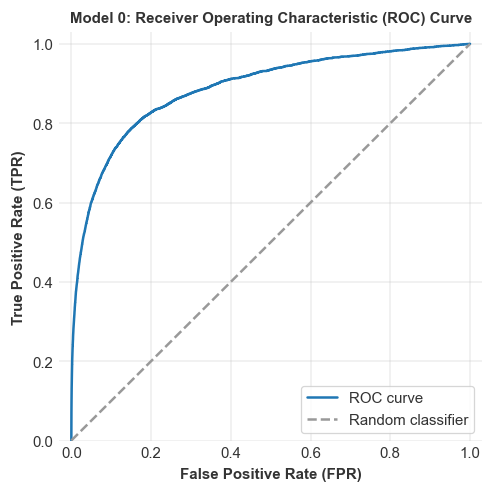

In [12]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

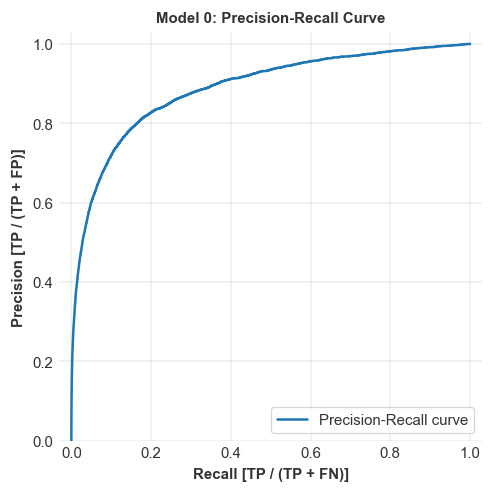

In [13]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [14]:

# -----------------------------
# Precision@K / Recall@K curves
# -----------------------------

def precision_recall_at_k(
    y_true: np.ndarray,
    y_score: np.ndarray,
    ks=(100, 500, 1000, 5000, 10000, 20000, 50000),
) -> pd.DataFrame:
    """
    Compute Precision@K and Recall@K for a binary classifier ranking.

    Parameters
    ----------
    y_true : array-like (n,)
        Binary labels {0,1}.
    y_score : array-like (n,)
        Model scores (higher = more likely positive).
    ks : iterable of int
        Cutoffs.

    Returns
    -------
    DataFrame with columns: K, tp, precision_at_k, recall_at_k.
    """
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score, dtype=float)

    if y_true.ndim != 1 or y_score.ndim != 1 or y_true.shape[0] != y_score.shape[0]:
        raise ValueError("y_true and y_score must be 1D arrays of the same length.")

    n = y_true.shape[0]
    pos_total = int(y_true.sum())
    if pos_total == 0:
        raise ValueError("y_true contains no positives; recall is undefined.")

    # sort descending by score
    order = np.argsort(-y_score, kind="mergesort")  # stable for ties
    y_sorted = y_true[order]

    # cumulative true positives along the ranked list
    ctp = np.cumsum(y_sorted)

    rows = []
    for K in ks:
        k = int(min(max(K, 1), n))
        tp = int(ctp[k - 1])
        precision = tp / k
        recall = tp / pos_total
        rows.append((k, tp, precision, recall))

    return pd.DataFrame(rows, columns=["K", "tp", "precision_at_k", "recall_at_k"])


def plot_precision_recall_at_k(pr_df: pd.DataFrame, title_prefix: str = "Validation"):
    """
    Plot Precision@K and Recall@K vs K (log-scaled x-axis).
    """
    ks = pr_df["K"].to_numpy()
    prec = pr_df["precision_at_k"].to_numpy()
    rec = pr_df["recall_at_k"].to_numpy()

    plt.figure(figsize=(9, 5))
    plt.plot(ks, prec, marker="o")
    plt.xscale("log")
    plt.xlabel("K (top-K flagged; log scale)")
    plt.ylabel("Precision@K")
    plt.title(f"{title_prefix}: Precision@K")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

    plt.figure(figsize=(9, 5))
    plt.plot(ks, rec, marker="o")
    plt.xscale("log")
    plt.xlabel("K (top-K flagged; log scale)")
    plt.ylabel("Recall@K")
    plt.title(f"{title_prefix}: Recall@K")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()



       K    tp  precision_at_k  recall_at_k
0    100    26         0.26000     0.005840
1    500    94         0.18800     0.021114
2   1000   176         0.17600     0.039533
3   5000   460         0.09200     0.103324
4  10000   653         0.06530     0.146676
5  20000   919         0.04595     0.206424
6  50000  1290         0.02580     0.289757


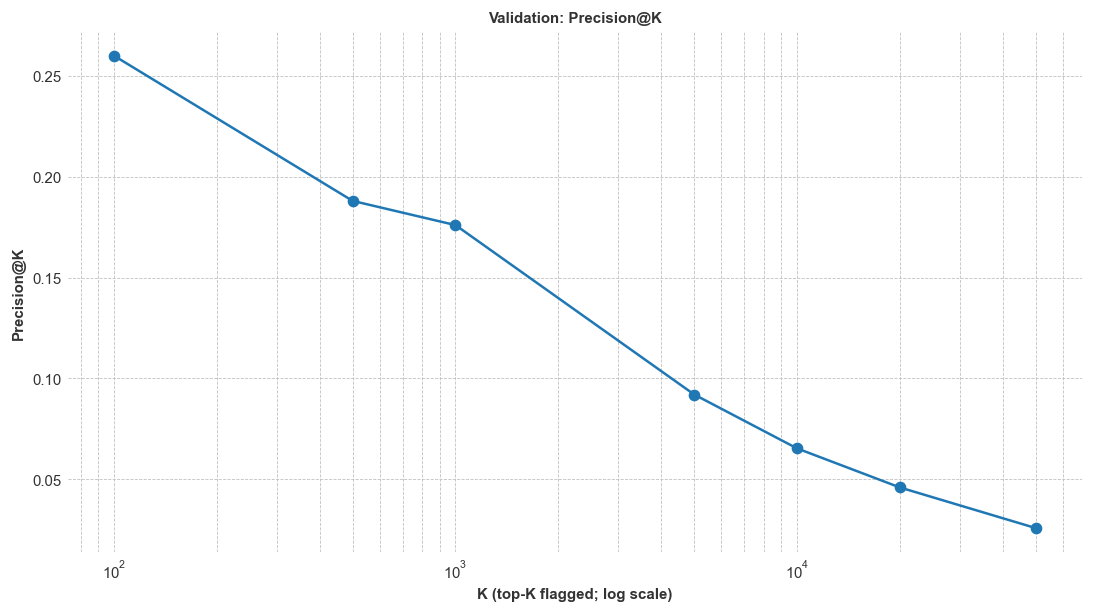

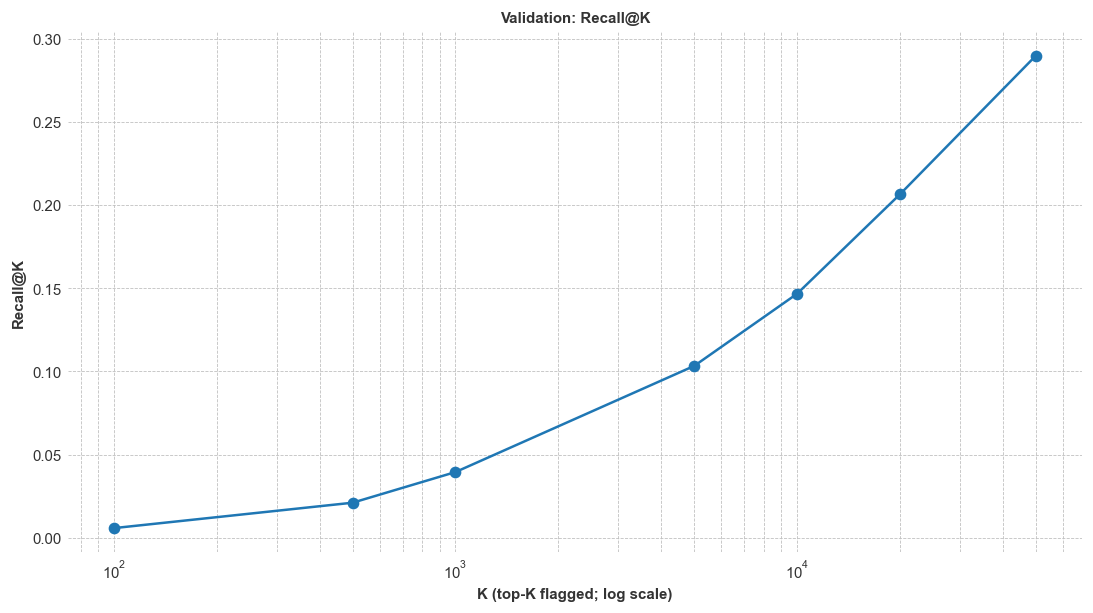

In [15]:
Ks = (100, 500, 1000, 5000, 10000, 20000, 50000)

pr_valid = precision_recall_at_k(y_valid.to_numpy(), p_valid, ks=Ks)
print(pr_valid)

plot_precision_recall_at_k(pr_valid, title_prefix="Validation")


#### Feature importance


In [16]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

feature  importance_gain
21    ab_nicu    874713.505083
46     mage_c    528692.513652
35   ca_disor    227301.840788
43       dbwt    167951.988727
27    ca_cchd    132412.431475
3   gestrec10    116704.382051
19   ab_aven1     79982.441388
44     wtgain     43350.768292
45        bmi     40729.280892
37  mracehisp     33530.854236
36      meduc     29443.009507
47   fagecomb     28827.861423
20   ab_aven6     27826.022063
2     precare     21102.991475
16  dmeth_rec     19774.356983
38      feduc     16067.372271
42       year     14681.350976
7    rf_ghype     14583.174357
39  fracehisp     12340.681589
0     bfacil3     12217.301434
10   rf_inftr     12168.629817
12   rf_artec     11741.618293
23    ab_anti      9544.186444
15    me_pres      7457.669091
40    pay_rec      5094.402590
33   ca_clpal      4050.628494
6    rf_phype      3830.059639
4    rf_pdiab      3575.088851
32   ca_cleft      3507.361783
11   rf_fedrg      3386.371611
29    ca_omph      2470.040038
17     apgar5      2244.214851
31    ca_limb      1951.482839
1         sex      1887.648551
8    rf_ehype      1786.572026
25    ca_anen      1486.676217
9   rf_ppterm      1484.085731
13    ld_indl      1213.257228
14    ld_augm      1166.478629
30    ca_gast      1116.973887
26    ca_mnsb      1104.354322
28     ca_cdh       694.991065
41        wic       526.629495
34    ca_hypo       508.439110
22    ab_surf       216.473917
18    apgar10       196.738871
5    rf_gdiab        80.138560
24    ab_seiz        36.908180

### Evaluation subset for permutation importances and SHAP analysis


In [17]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

In [18]:
model_wrapped = ml_utils.LGBMEstimator(gbm)

In [19]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

feature  importance_mean  importance_std
27    ca_cchd     1.213566e-02        0.000448
46     mage_c     1.195861e-02        0.000563
35   ca_disor     1.152030e-02        0.000407
21    ab_nicu     5.634003e-03        0.000602
43       dbwt     3.481855e-03        0.000329
3   gestrec10     2.034893e-03        0.000310
16  dmeth_rec     1.709356e-03        0.000441
20   ab_aven6     1.079654e-03        0.000148
0     bfacil3     9.797260e-04        0.000200
44     wtgain     9.666577e-04        0.000201
19   ab_aven1     8.583365e-04        0.000222
36      meduc     8.015534e-04        0.000230
42       year     6.228243e-04        0.000212
37  mracehisp     6.035426e-04        0.000245
45        bmi     5.470920e-04        0.000210
2     precare     4.513380e-04        0.000251
23    ab_anti     3.261423e-04        0.000160
6    rf_phype     2.862894e-04        0.000096
15    me_pres     2.728218e-04        0.000162
1         sex     2.503198e-04        0.000113
38      feduc     1.987356e-04        0.000123
9   rf_ppterm     1.694509e-04        0.000051
7    rf_ghype     1.479096e-04        0.000204
40    pay_rec     1.402312e-04        0.000056
26    ca_mnsb     5.987612e-05        0.000022
41        wic     5.705644e-05        0.000034
10   rf_inftr     5.657812e-05        0.000090
32   ca_cleft     4.233250e-05        0.000018
31    ca_limb     3.677395e-05        0.000013
25    ca_anen     2.799103e-05        0.000075
17     apgar5     2.543389e-05        0.000050
33   ca_clpal     1.470826e-05        0.000033
14    ld_augm     1.382984e-05        0.000081
13    ld_indl     7.825136e-06        0.000016
12   rf_artec     7.082568e-06        0.000083
5    rf_gdiab     4.513768e-06        0.000004
30    ca_gast     3.964968e-06        0.000010
28     ca_cdh     2.397303e-06        0.000003
34    ca_hypo     1.167219e-06        0.000004
24    ab_seiz     1.043964e-06        0.000001
8    rf_ehype    -7.474313e-08        0.000037
18    apgar10    -2.340042e-06        0.000001
22    ab_surf    -1.416487e-05        0.000025
29    ca_omph    -2.149991e-05        0.000031
11   rf_fedrg    -2.782725e-05        0.000050
4    rf_pdiab    -3.002609e-05        0.000092
39  fracehisp    -4.613936e-05        0.000132
47   fagecomb    -8.331121e-05        0.000109

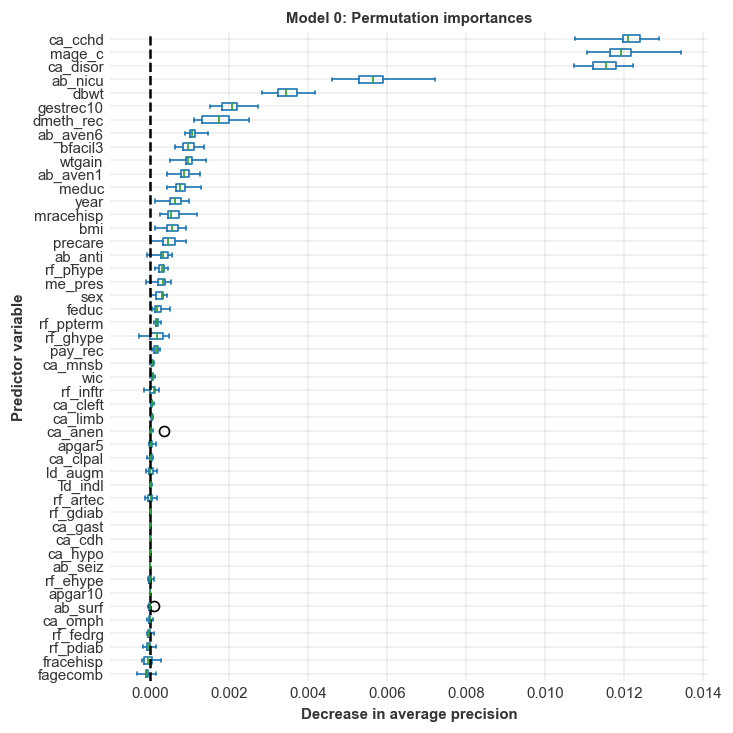

In [20]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

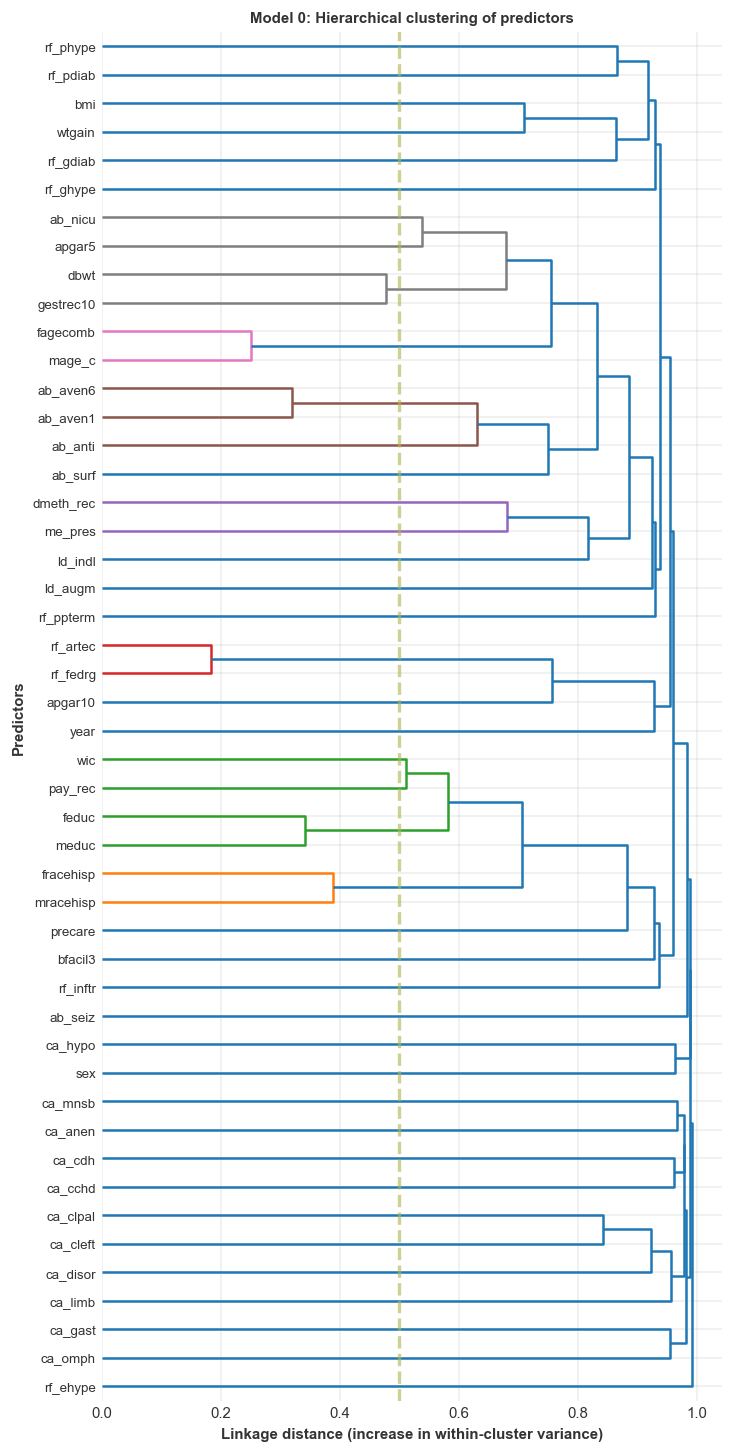

In [21]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

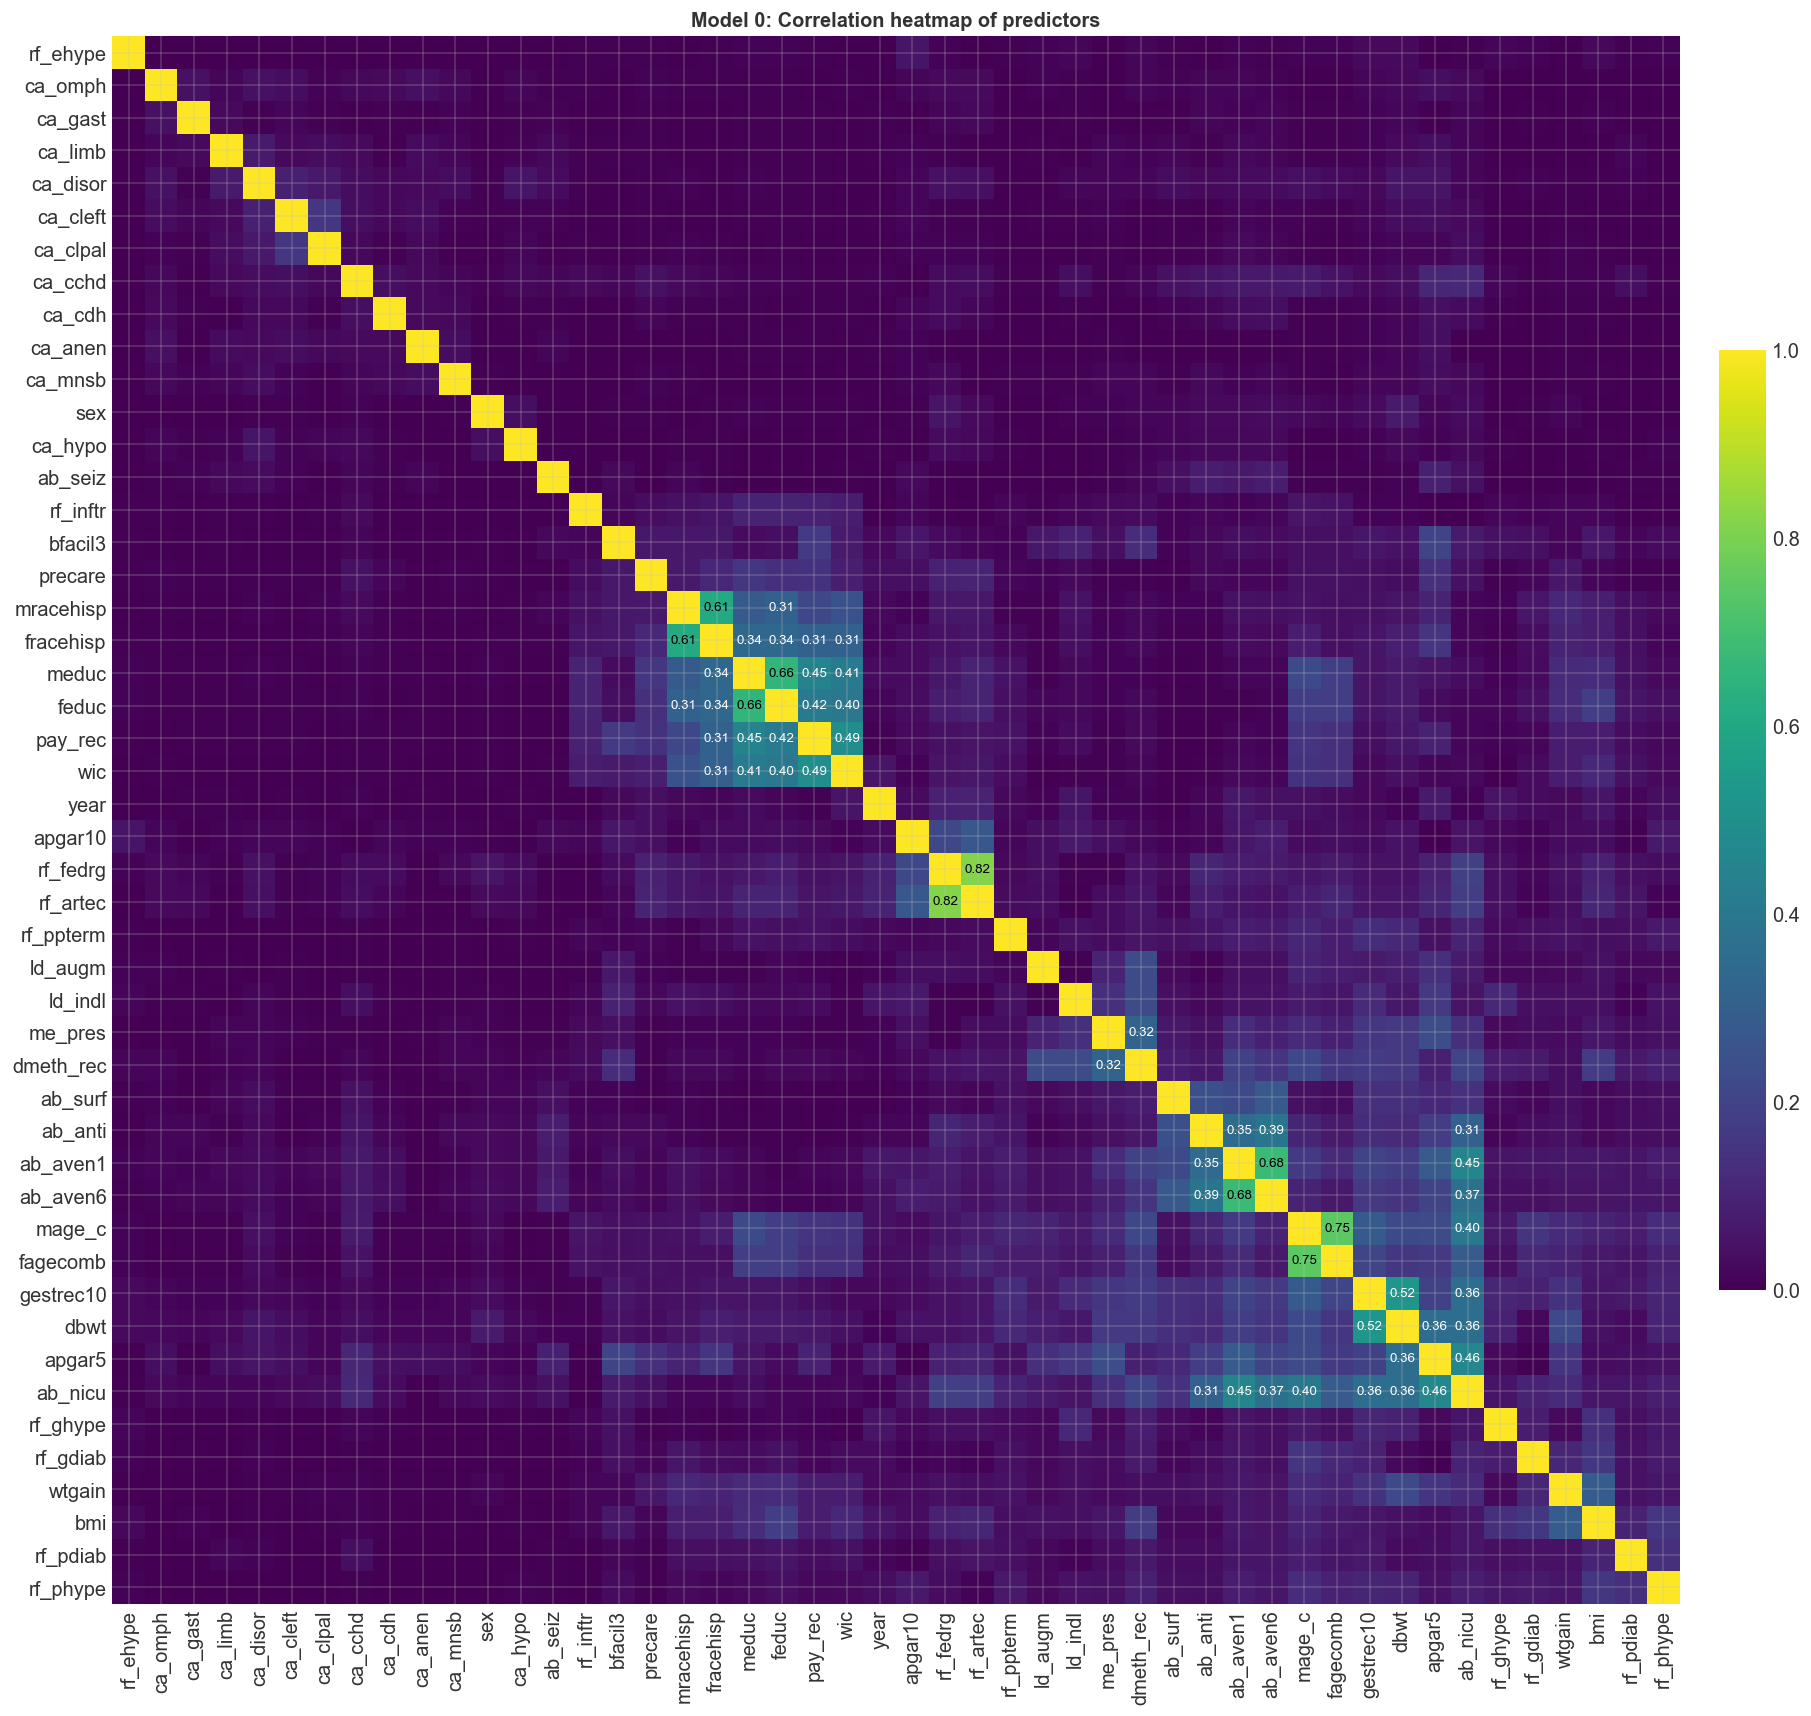

In [22]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [23]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\

feature  mean_abs_shap
21    ab_nicu       0.943188
46     mage_c       0.744885
43       dbwt       0.345574
3   gestrec10       0.300090
19   ab_aven1       0.204805
37  mracehisp       0.118776
44     wtgain       0.085300
27    ca_cchd       0.081673
35   ca_disor       0.073327
16  dmeth_rec       0.058336
36      meduc       0.056699
42       year       0.055769
20   ab_aven6       0.052755
7    rf_ghype       0.044416
2     precare       0.044100
39  fracehisp       0.040495
45        bmi       0.036337
15    me_pres       0.033783
38      feduc       0.033702
23    ab_anti       0.031970
47   fagecomb       0.027620
0     bfacil3       0.025617
40    pay_rec       0.017015
10   rf_inftr       0.015654
6    rf_phype       0.009585
1         sex       0.008516
12   rf_artec       0.008436
4    rf_pdiab       0.006398
17     apgar5       0.006145
14    ld_augm       0.005364
9   rf_ppterm       0.004032
11   rf_fedrg       0.003855
13    ld_indl       0.003583
33   ca_clpal       0.003515
32   ca_cleft       0.003202
8    rf_ehype       0.001958
25    ca_anen       0.001941
41        wic       0.001658
31    ca_limb       0.001472
29    ca_omph       0.001433
26    ca_mnsb       0.000847
30    ca_gast       0.000734
34    ca_hypo       0.000574
28     ca_cdh       0.000372
22    ab_surf       0.000293
18    apgar10       0.000234
5    rf_gdiab       0.000133
24    ab_seiz       0.000021

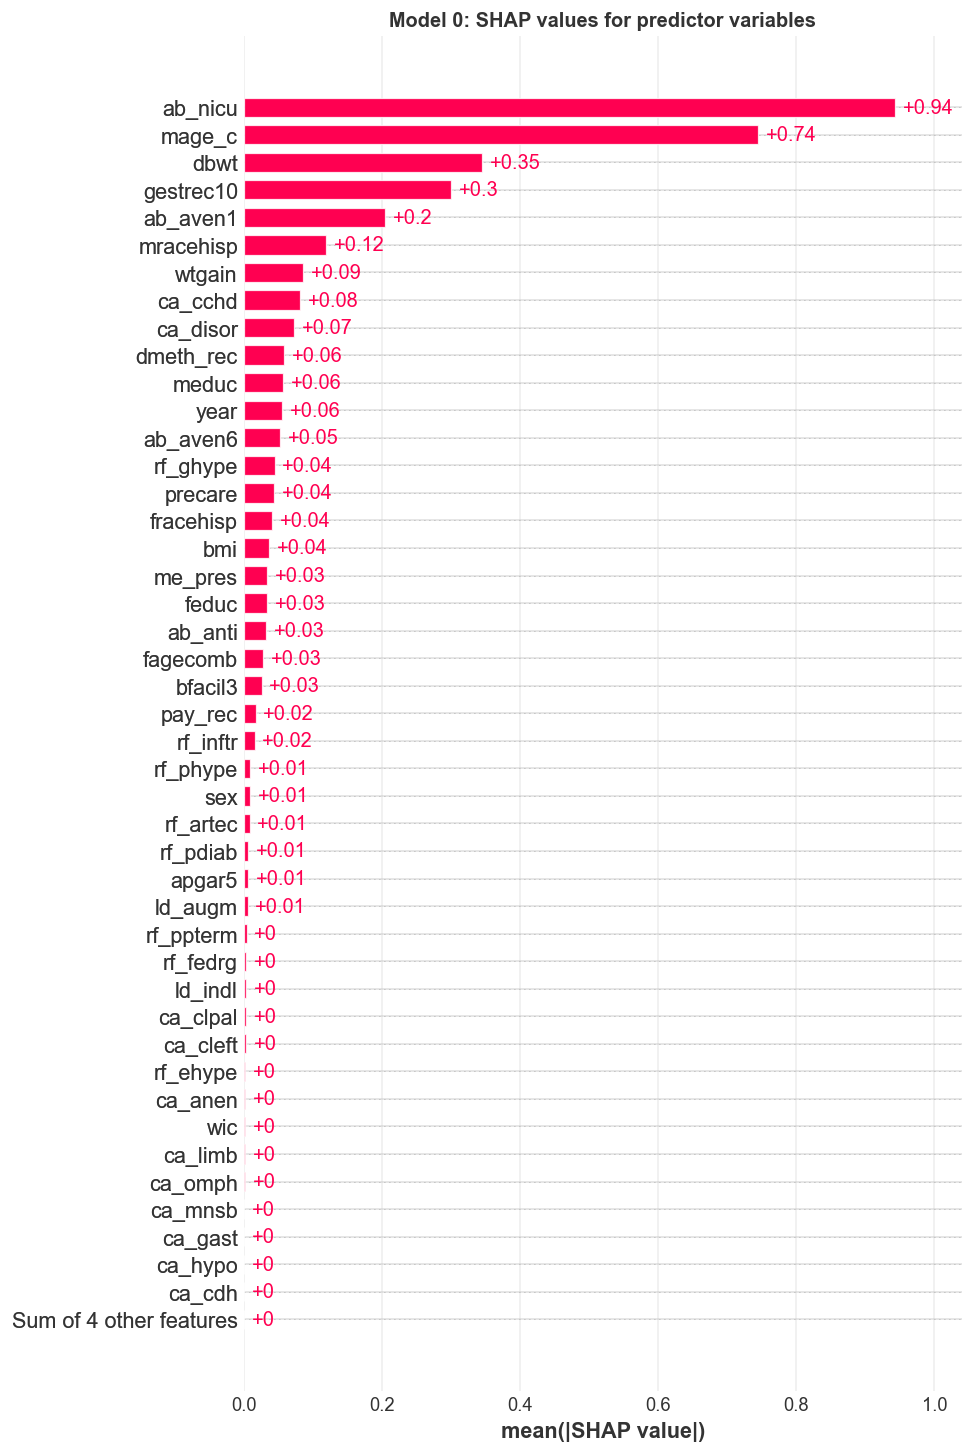

<Figure size 492x348 with 0 Axes>

In [24]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 12))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=45, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

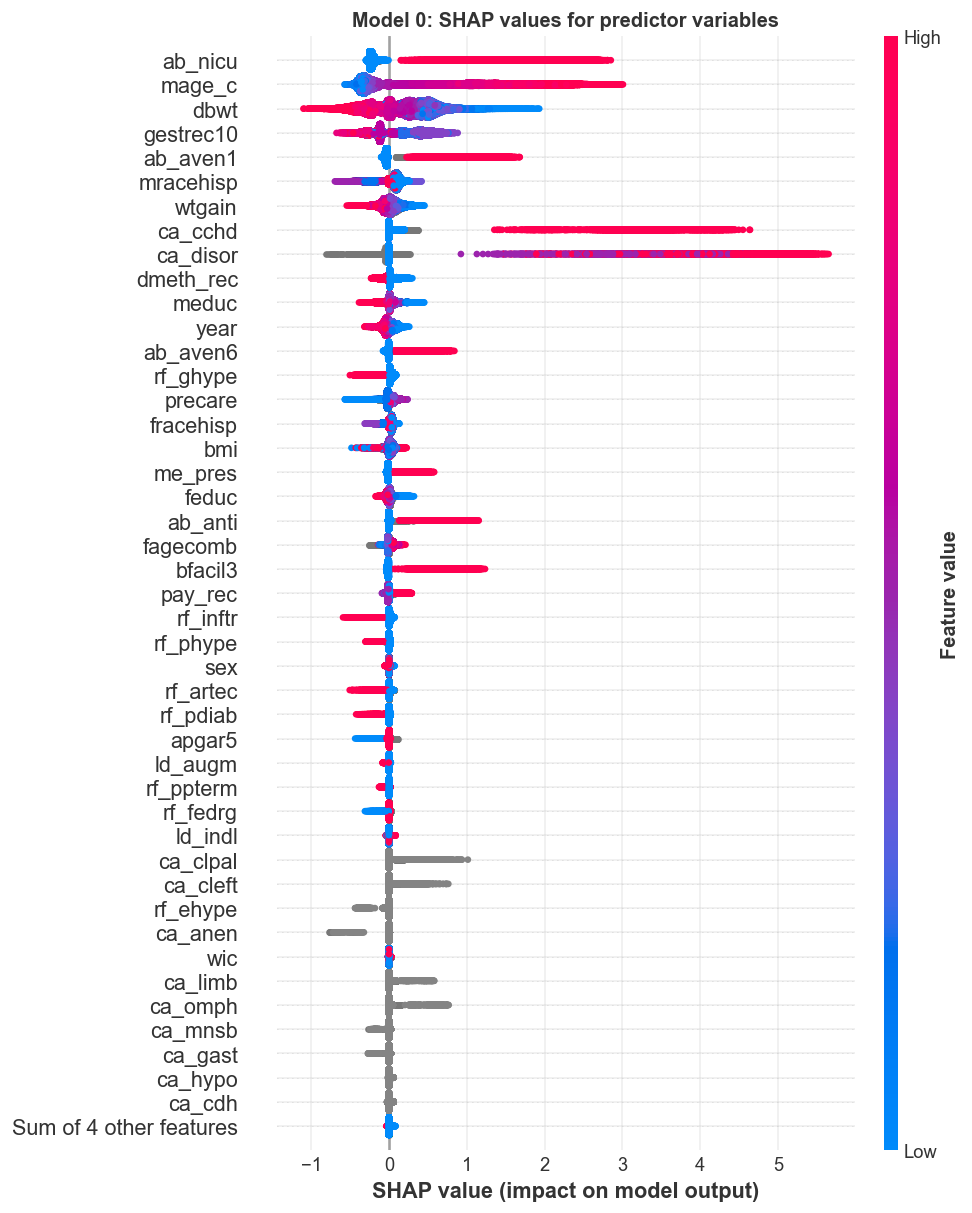

<Figure size 492x348 with 0 Axes>

In [25]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=45, plot_size=(8, 10))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

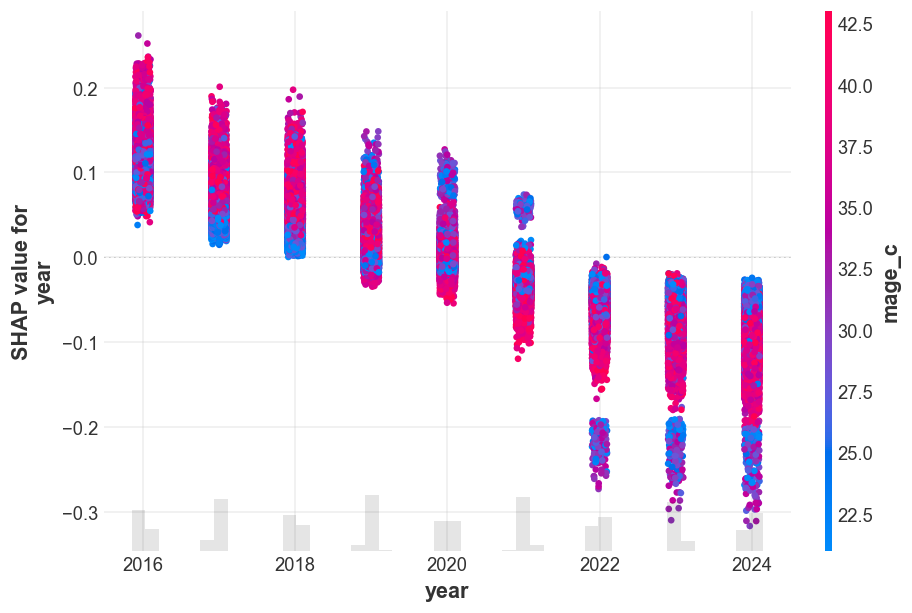

<Figure size 492x348 with 0 Axes>

In [26]:
ax = shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
# ax.set_title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 1


In [27]:
features_to_remove_0 = [
    "ca_cdh",
    "apgar10",
    "ca_cleft",
    "rf_artec",
    "ca_omph",
    "ca_clpal",
    "wic",
    "ca_limb"
]

X_train = X_train.drop(columns=features_to_remove_0)
X_valid = X_valid.drop(columns=features_to_remove_0)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_0]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 1
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_0)} predictors)"
)

print(f"Features removed: {features_to_remove_0}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['ca_cdh', 'apgar10', 'ca_cleft', 'rf_artec', 'ca_omph', 'ca_clpal', 'wic', 'ca_limb']
Features remaining: ['bfacil3', 'sex', 'precare', 'gestrec10', 'rf_pdiab', 'rf_gdiab', 'rf_phype', 'rf_ghype', 'rf_ehype', 'rf_ppterm', 'rf_inftr', 'rf_fedrg', 'ld_indl', 'ld_augm', 'me_pres', 'dmeth_rec', 'apgar5', 'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_surf', 'ab_anti', 'ab_seiz', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_gast', 'ca_hypo', 'ca_disor', 'meduc', 'mracehisp', 'feduc', 'fracehisp', 'pay_rec', 'year', 'dbwt', 'wtgain', 'bmi', 'mage_c', 'fagecomb']
Number of features in Model 1 (after removing 8 predictors): 40


In [28]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	train's average_precision: 0.0310636	train's binary_logloss: 0.00418232	valid's average_precision: 0.0272704	valid's binary_logloss: 0.00419899
[20]	train's average_precision: 0.0329109	train's binary_logloss: 0.0040543	valid's average_precision: 0.0279894	valid's binary_logloss: 0.00407714
[30]	train's average_precision: 0.0339831	train's binary_logloss: 0.00396969	valid's average_precision: 0.0283852	valid's binary_logloss: 0.00399714
[40]	train's average_precision: 0.0347397	train's binary_logloss: 0.00390573	valid's average_precision: 0.0287989	valid's binary_logloss: 0.00393699
[50]	t

In [29]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [30]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds, tp, fp, n_pos = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

metric     value
0              Validation AUC  0.887685
1               Validation AP  0.031104
2         Validation log loss  0.003602
3          Precision at 10000  0.066100
4             Recall at 10000  0.148473
5  Precision (threshold=0.01)  0.027682
6     Recall (threshold=0.01)  0.276730

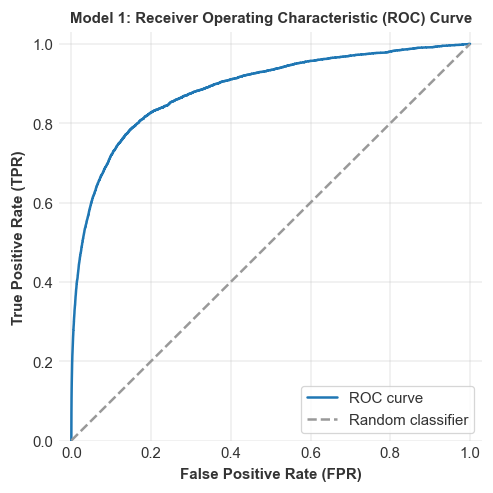

In [31]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

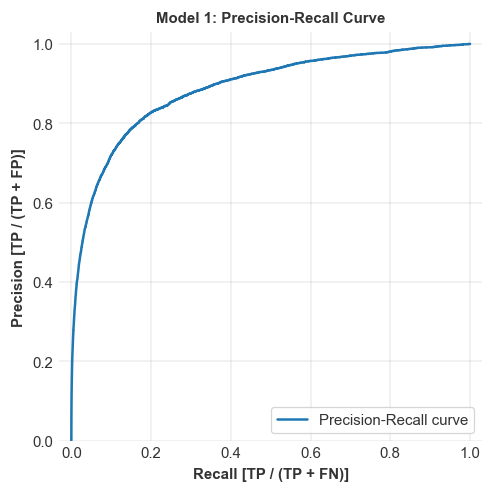

In [32]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [33]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

feature  importance_gain
19    ab_nicu    874744.278087
38     mage_c    528142.224097
28   ca_disor    230392.607766
35       dbwt    176528.857242
25    ca_cchd    134899.680241
3   gestrec10    117092.610703
17   ab_aven1     93079.845543
36     wtgain     49088.015712
37        bmi     46711.742727
30  mracehisp     35702.790291
29      meduc     32074.269331
39   fagecomb     29916.454480
2     precare     25496.053472
18   ab_aven6     20706.403106
15  dmeth_rec     20501.519315
31      feduc     18432.696236
34       year     16528.066825
7    rf_ghype     15028.221175
32  fracehisp     14181.346945
11   rf_fedrg     13020.795972
0     bfacil3     12554.045064
10   rf_inftr     12231.428124
21    ab_anti      9523.062686
14    me_pres      7960.315697
33    pay_rec      6025.491829
6    rf_phype      4351.764332
4    rf_pdiab      3858.734350
27    ca_hypo      3273.384109
26    ca_gast      2680.836466
23    ca_anen      2546.103290
16     apgar5      2450.347092
1         sex      2253.328677
24    ca_mnsb      2153.566155
8    rf_ehype      1962.795746
9   rf_ppterm      1647.275605
12    ld_indl      1505.808480
13    ld_augm      1228.927033
20    ab_surf       285.764438
5    rf_gdiab        92.267190
22    ab_seiz         7.817040

In [34]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [35]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

feature  importance_mean  importance_std
25    ca_cchd         0.011799    2.746883e-04
38     mage_c         0.011545    3.990497e-04
28   ca_disor         0.011153    5.159512e-04
19    ab_nicu         0.005284    4.861532e-04
35       dbwt         0.003410    4.532851e-04
3   gestrec10         0.001797    4.726639e-04
15  dmeth_rec         0.001576    3.892674e-04
17   ab_aven1         0.001145    2.131169e-04
36     wtgain         0.000900    3.396305e-04
18   ab_aven6         0.000821    1.471785e-04
0     bfacil3         0.000811    1.734729e-04
29      meduc         0.000705    2.011350e-04
34       year         0.000542    2.095608e-04
37        bmi         0.000528    2.285891e-04
30  mracehisp         0.000402    2.335412e-04
14    me_pres         0.000330    1.340140e-04
2     precare         0.000289    2.523951e-04
31      feduc         0.000288    1.590098e-04
6    rf_phype         0.000280    1.169684e-04
1         sex         0.000256    9.532215e-05
21    ab_anti         0.000175    1.397258e-04
7    rf_ghype         0.000165    1.792169e-04
33    pay_rec         0.000111    7.698458e-05
9   rf_ppterm         0.000100    9.167016e-05
10   rf_inftr         0.000099    1.122558e-04
16     apgar5         0.000094    7.488652e-05
20    ab_surf         0.000084    1.948964e-05
13    ld_augm         0.000083    8.383237e-05
22    ab_seiz         0.000073    7.816769e-07
12    ld_indl         0.000053    3.054296e-05
24    ca_mnsb         0.000046    5.643004e-05
23    ca_anen         0.000036    6.232827e-05
27    ca_hypo         0.000015    6.990599e-06
26    ca_gast         0.000011    2.113902e-05
32  fracehisp         0.000010    1.241231e-04
5    rf_gdiab         0.000003    2.678109e-06
11   rf_fedrg        -0.000004    8.058821e-05
8    rf_ehype        -0.000020    3.297114e-05
4    rf_pdiab        -0.000059    1.100093e-04
39   fagecomb        -0.000060    1.687371e-04

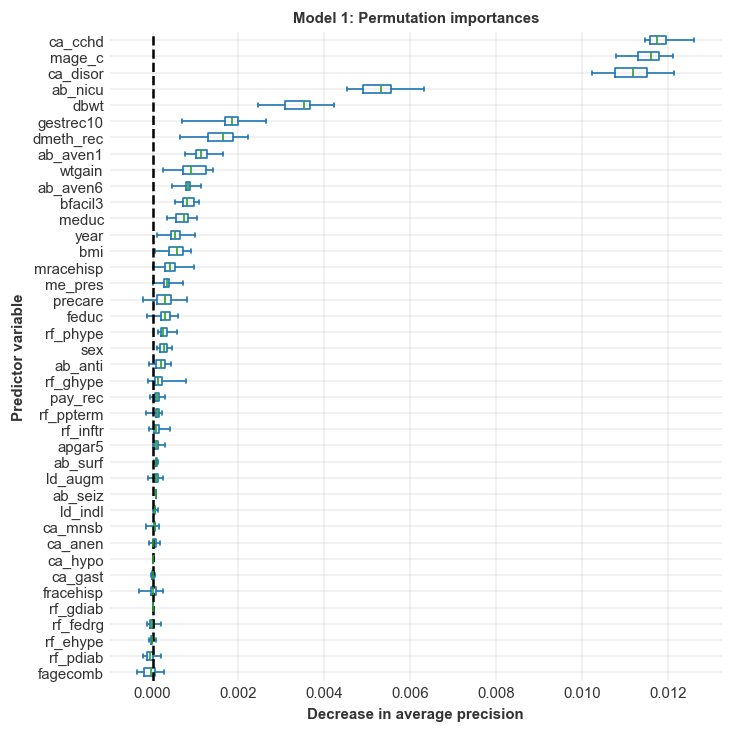

In [36]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

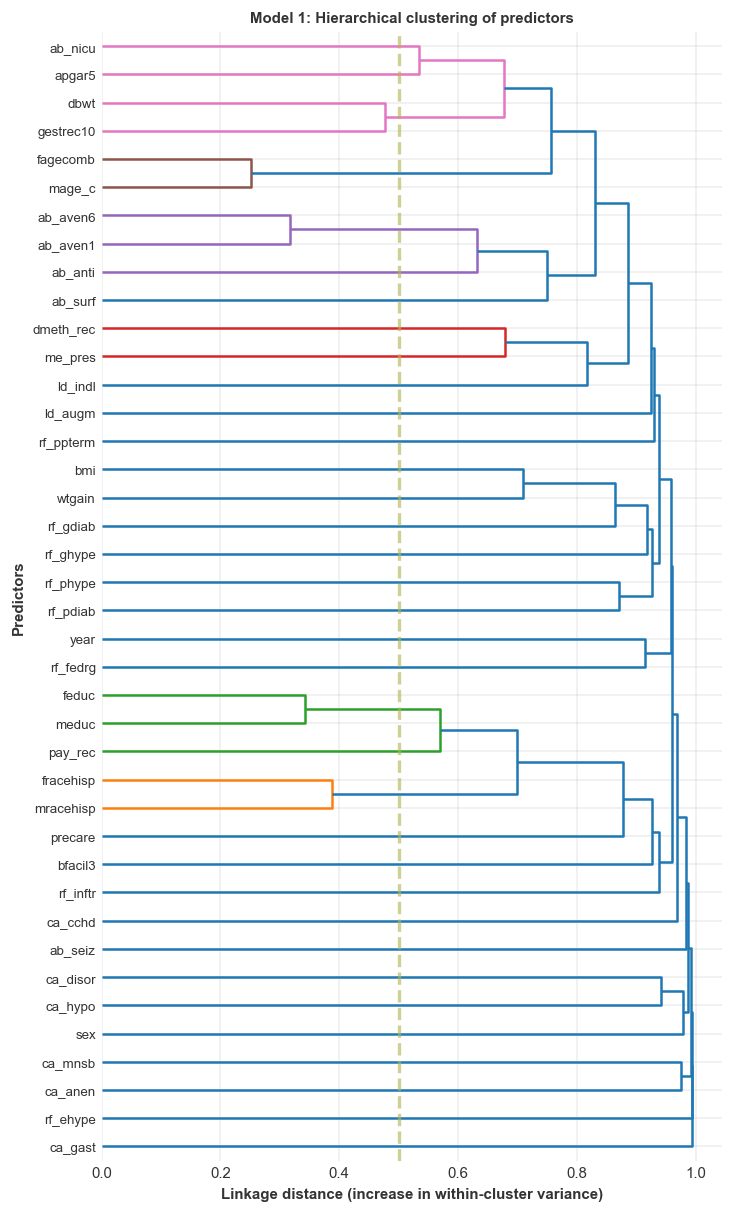

In [37]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

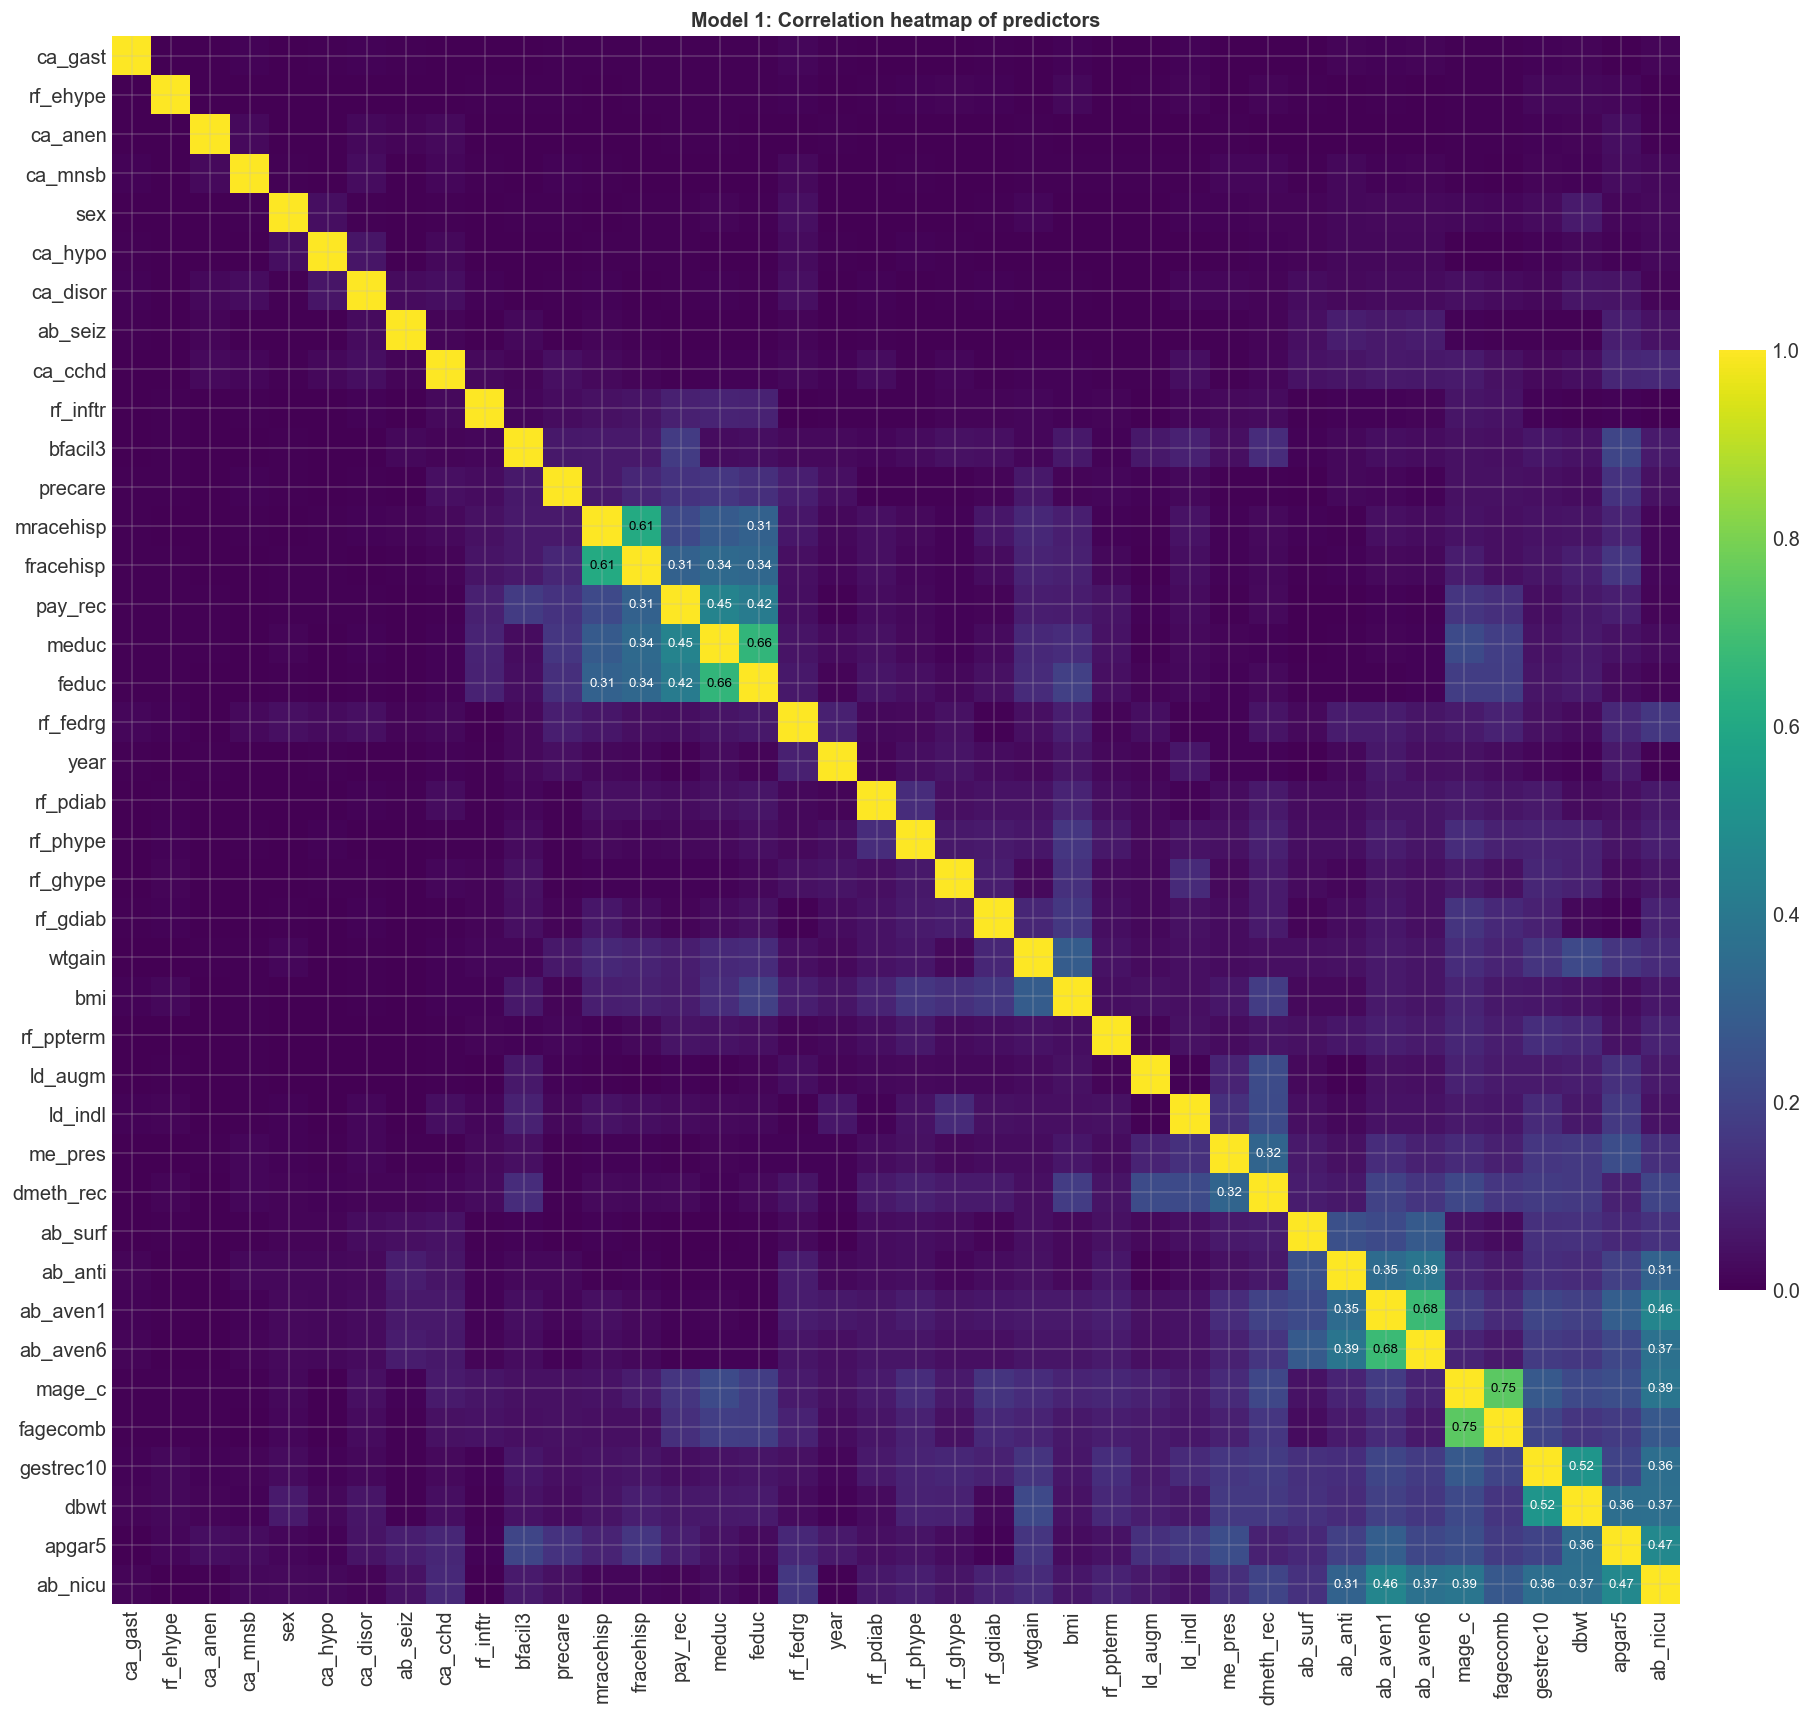

In [38]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [39]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\

feature  mean_abs_shap
19    ab_nicu       0.947129
38     mage_c       0.758391
35       dbwt       0.359377
3   gestrec10       0.306800
17   ab_aven1       0.212219
30  mracehisp       0.125310
36     wtgain       0.088768
25    ca_cchd       0.081895
28   ca_disor       0.073957
34       year       0.064703
15  dmeth_rec       0.061895
29      meduc       0.060075
18   ab_aven6       0.053595
2     precare       0.048673
7    rf_ghype       0.047674
32  fracehisp       0.044761
37        bmi       0.040089
31      feduc       0.039010
14    me_pres       0.038385
21    ab_anti       0.031230
0     bfacil3       0.027868
39   fagecomb       0.024587
33    pay_rec       0.020826
10   rf_inftr       0.018387
6    rf_phype       0.010446
11   rf_fedrg       0.009853
16     apgar5       0.009511
1         sex       0.008842
4    rf_pdiab       0.007207
13    ld_augm       0.006182
12    ld_indl       0.005898
9   rf_ppterm       0.004791
27    ca_hypo       0.003754
23    ca_anen       0.003030
8    rf_ehype       0.002327
24    ca_mnsb       0.002024
26    ca_gast       0.001446
20    ab_surf       0.000430
5    rf_gdiab       0.000334
22    ab_seiz       0.000007

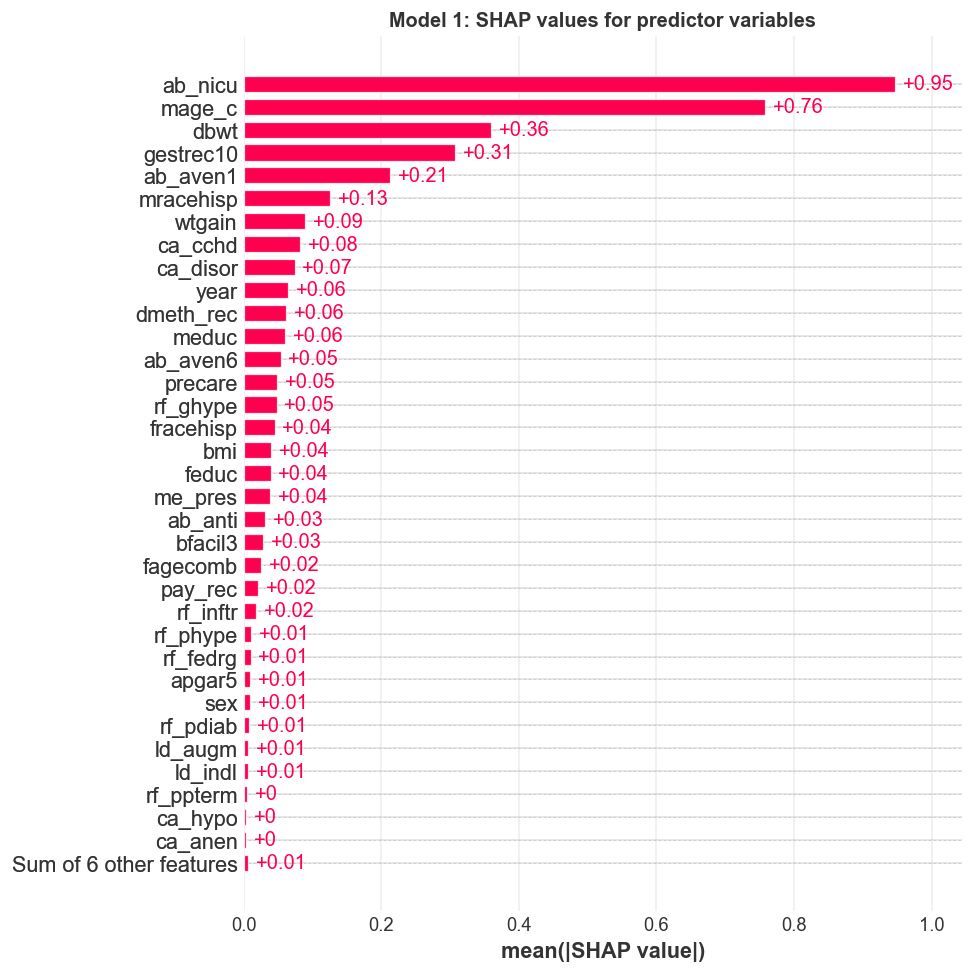

<Figure size 492x348 with 0 Axes>

In [40]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

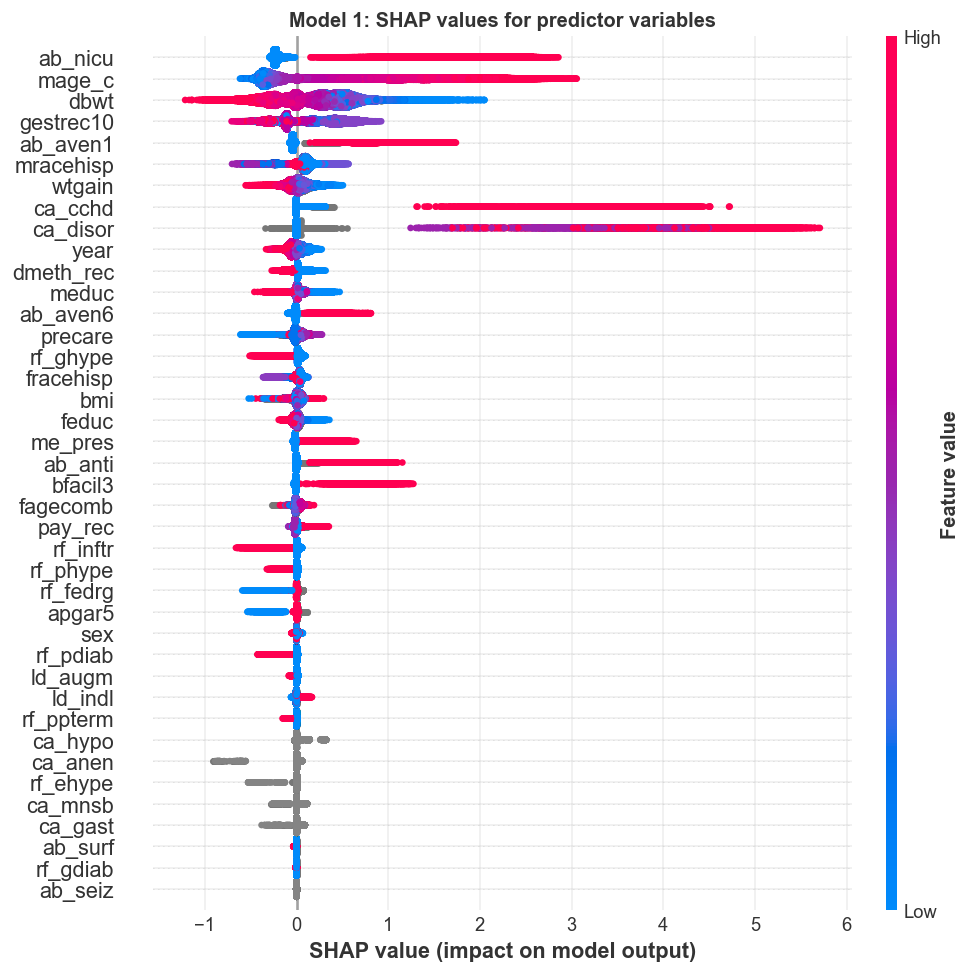

<Figure size 492x348 with 0 Axes>

In [41]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=40, plot_size=(8, 8))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

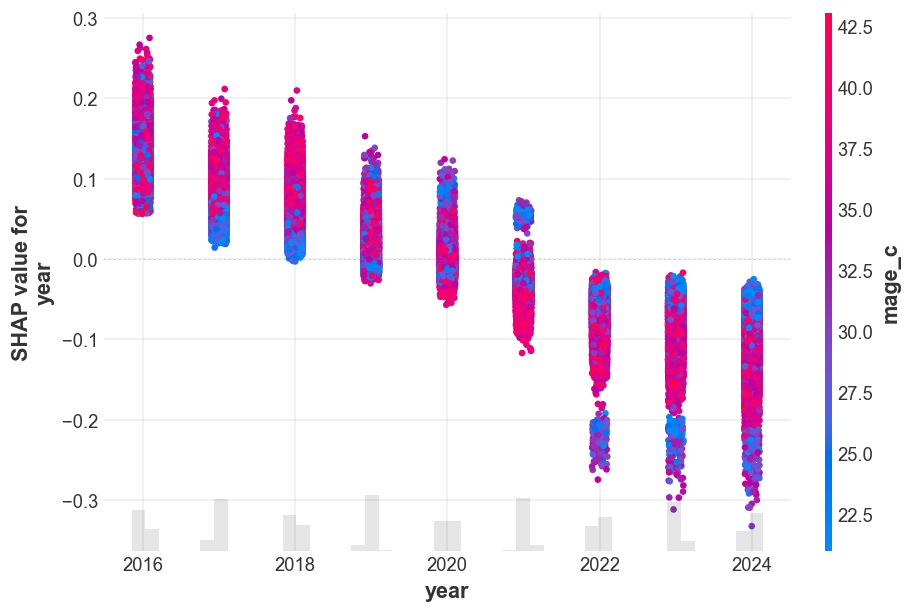

<Figure size 492x348 with 0 Axes>

In [42]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
#plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 2


In [43]:
features_to_remove_1 = [
    "rf_pdiab",
    "ca_hypo",
    "rf_ppterm",
    "ca_mnsb",
    "rf_ehype",
    "ca_anen",
    "ca_gast",
    "ab_surf",
    "rf_gdiab",
    "ab_seiz",
]

X_train = X_train.drop(columns=features_to_remove_1)
X_valid = X_valid.drop(columns=features_to_remove_1)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_1]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 2
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_1)} predictors)"
)

print(f"Features removed: {features_to_remove_1}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['rf_pdiab', 'ca_hypo', 'rf_ppterm', 'ca_mnsb', 'rf_ehype', 'ca_anen', 'ca_gast', 'ab_surf', 'rf_gdiab', 'ab_seiz']
Features remaining: ['bfacil3', 'sex', 'precare', 'gestrec10', 'rf_phype', 'rf_ghype', 'rf_inftr', 'rf_fedrg', 'ld_indl', 'ld_augm', 'me_pres', 'dmeth_rec', 'apgar5', 'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_anti', 'ca_cchd', 'ca_disor', 'meduc', 'mracehisp', 'feduc', 'fracehisp', 'pay_rec', 'year', 'dbwt', 'wtgain', 'bmi', 'mage_c', 'fagecomb']
Number of features in Model 2 (after removing 10 predictors): 30


In [44]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 13357, number of negative: 25178564
[LightGBM] [Info] Total Bins 840
[LightGBM] [Info] Number of data points in the train set: 25191921, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541708
[LightGBM] [Info] Start training from score -7.541708
Training until validation scores don't improve for 250 rounds
[10]	train's average_precision: 0.0310186	train's binary_logloss: 0.00418807	valid's average_precision: 0.0273668	valid's binary_logloss: 0.00420337
[20]	train's average_precision: 0.0323001	train's binary_logloss: 0.00407123	valid's average_precision: 0.0279519	valid's binary_logloss: 0.00409246
[30]	train's average_precision: 0.0332304	train's binary_logloss: 0.00397931	valid's average_precision: 0.0284458	valid's binary_logloss: 0.00400539
[40]	train's average_precision: 0.034008	train's binary_logloss: 0.0039107	valid's average_precision: 0.0289868	valid's binary_logloss: 0.00394057
[50]	tr

In [45]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [46]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds, tp, fp, n_pos = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

metric     value
0              Validation AUC  0.887179
1               Validation AP  0.031489
2         Validation log loss  0.003606
3          Precision at 10000  0.066300
4             Recall at 10000  0.148922
5  Precision (threshold=0.01)  0.027700
6     Recall (threshold=0.01)  0.272686

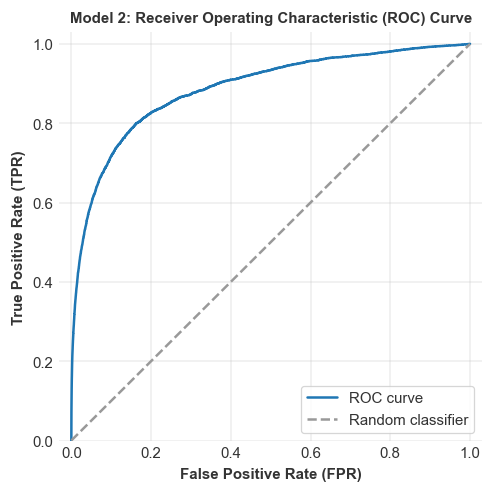

In [47]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

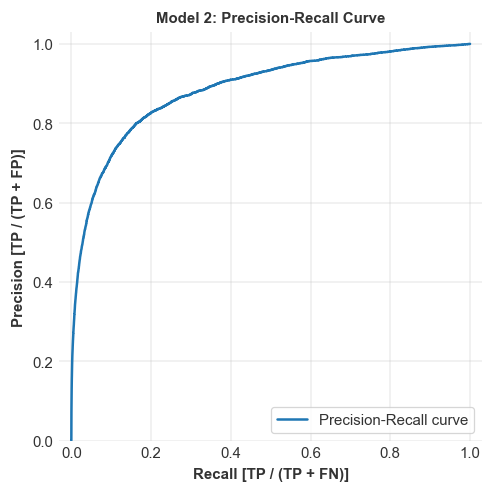

In [48]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

       K    tp  precision_at_k  recall_at_k
0    100    30         0.30000     0.006739
1    500    90         0.18000     0.020216
2   1000   180         0.18000     0.040431
3   5000   451         0.09020     0.101303
4  10000   663         0.06630     0.148922
5  20000   912         0.04560     0.204852
6  50000  1276         0.02552     0.286613


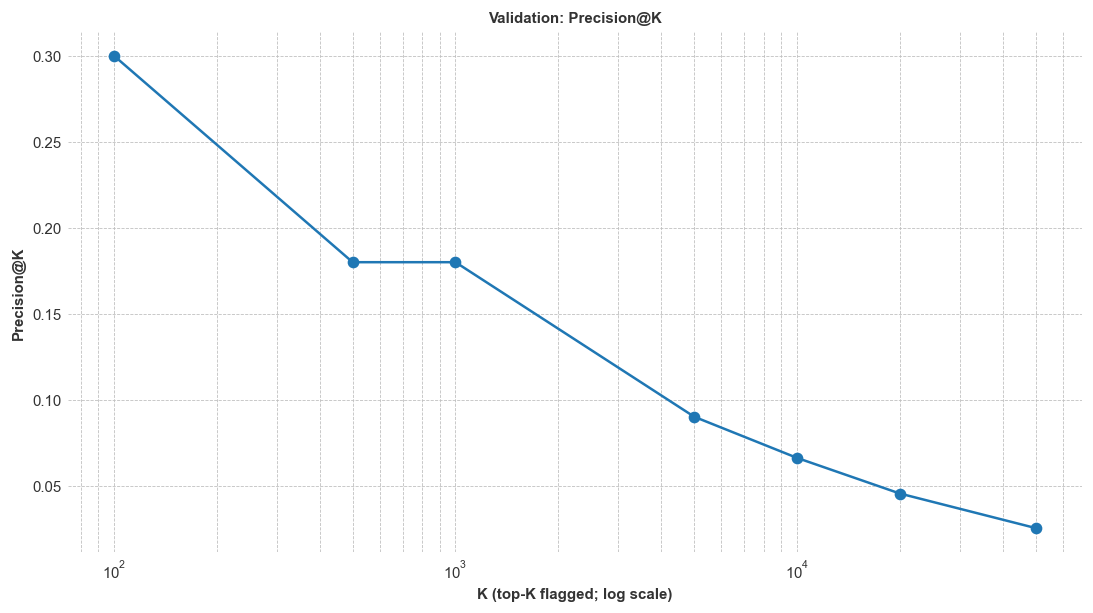

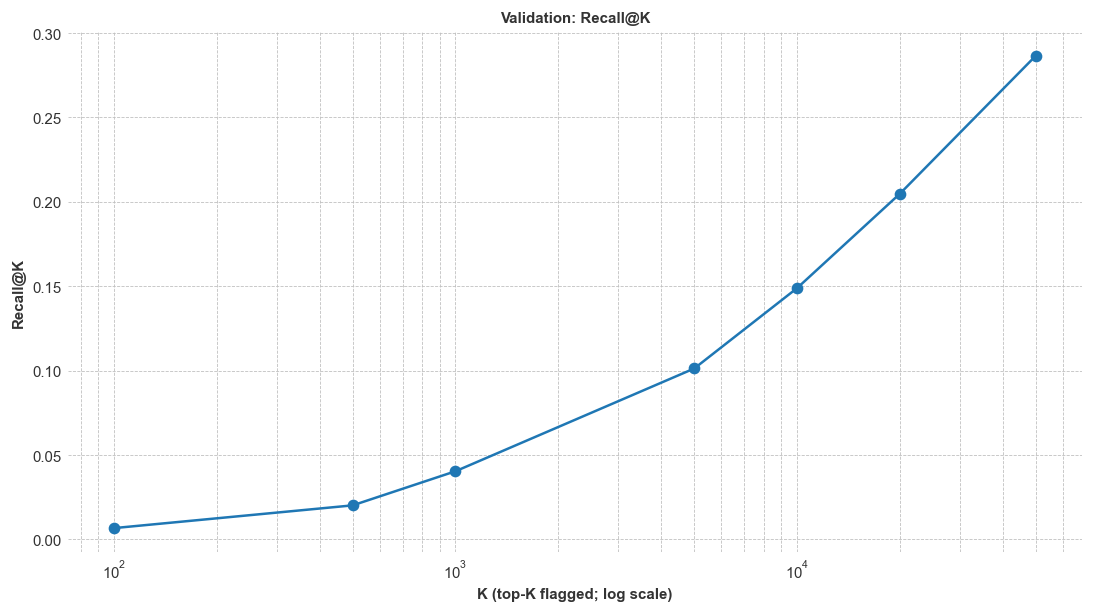

In [49]:

pr_valid = precision_recall_at_k(y_valid.to_numpy(), p_valid, ks=Ks)
print(pr_valid)

plot_precision_recall_at_k(pr_valid, title_prefix="Validation")


In [50]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

feature  importance_gain
15    ab_nicu    882014.509258
28     mage_c    488983.079273
18   ca_disor    224566.940611
25       dbwt    176404.990631
17    ca_cchd    148653.179132
3   gestrec10    115845.487336
13   ab_aven1    101493.277367
29   fagecomb     46893.650495
26     wtgain     46482.907857
27        bmi     44104.115299
20  mracehisp     34029.682459
19      meduc     30099.038403
2     precare     22788.928316
11  dmeth_rec     18629.475717
14   ab_aven6     18014.702546
21      feduc     16910.568903
24       year     15695.559446
5    rf_ghype     14456.396358
7    rf_fedrg     13712.383216
22  fracehisp     12800.311403
6    rf_inftr     12475.610770
0     bfacil3     12399.472248
16    ab_anti     10489.443274
10    me_pres      7775.945961
23    pay_rec      5560.762799
4    rf_phype      4232.475744
12     apgar5      2480.466761
1         sex      2140.326840
8     ld_indl      1333.254101
9     ld_augm      1249.421654

In [51]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [52]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

feature  importance_mean  importance_std
28     mage_c         0.012025        0.000487
17    ca_cchd         0.012020        0.000515
18   ca_disor         0.011059        0.000475
15    ab_nicu         0.005391        0.000499
25       dbwt         0.003376        0.000461
3   gestrec10         0.002017        0.000352
11  dmeth_rec         0.001430        0.000535
13   ab_aven1         0.001129        0.000187
0     bfacil3         0.000888        0.000173
19      meduc         0.000773        0.000151
14   ab_aven6         0.000713        0.000147
26     wtgain         0.000699        0.000247
27        bmi         0.000563        0.000240
24       year         0.000514        0.000221
20  mracehisp         0.000454        0.000209
2     precare         0.000419        0.000216
10    me_pres         0.000318        0.000123
4    rf_phype         0.000306        0.000115
16    ab_anti         0.000214        0.000119
21      feduc         0.000189        0.000096
23    pay_rec         0.000169        0.000053
1         sex         0.000151        0.000075
6    rf_inftr         0.000121        0.000112
5    rf_ghype         0.000107        0.000245
12     apgar5         0.000043        0.000037
9     ld_augm         0.000037        0.000052
8     ld_indl         0.000034        0.000020
7    rf_fedrg         0.000023        0.000114
22  fracehisp        -0.000050        0.000085
29   fagecomb        -0.000128        0.000153

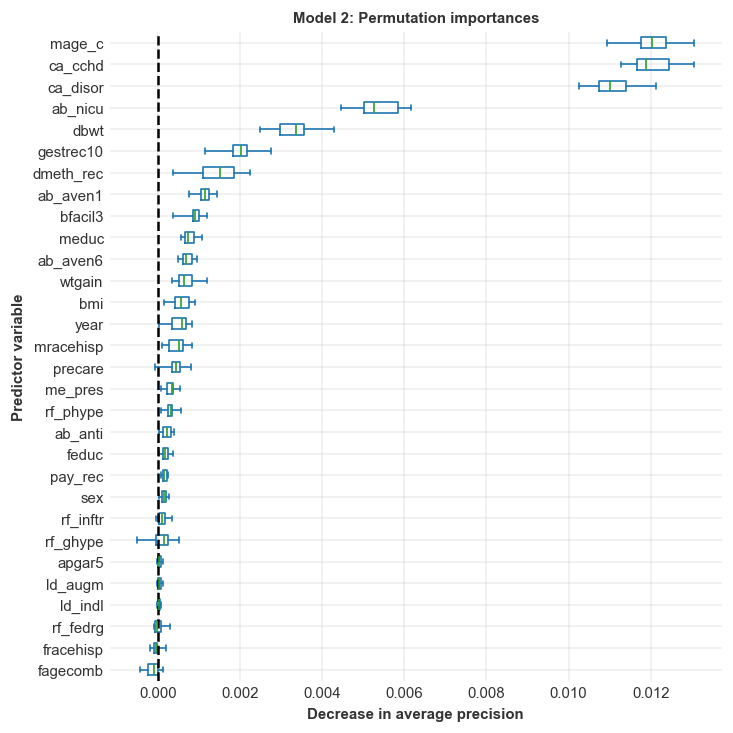

In [53]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

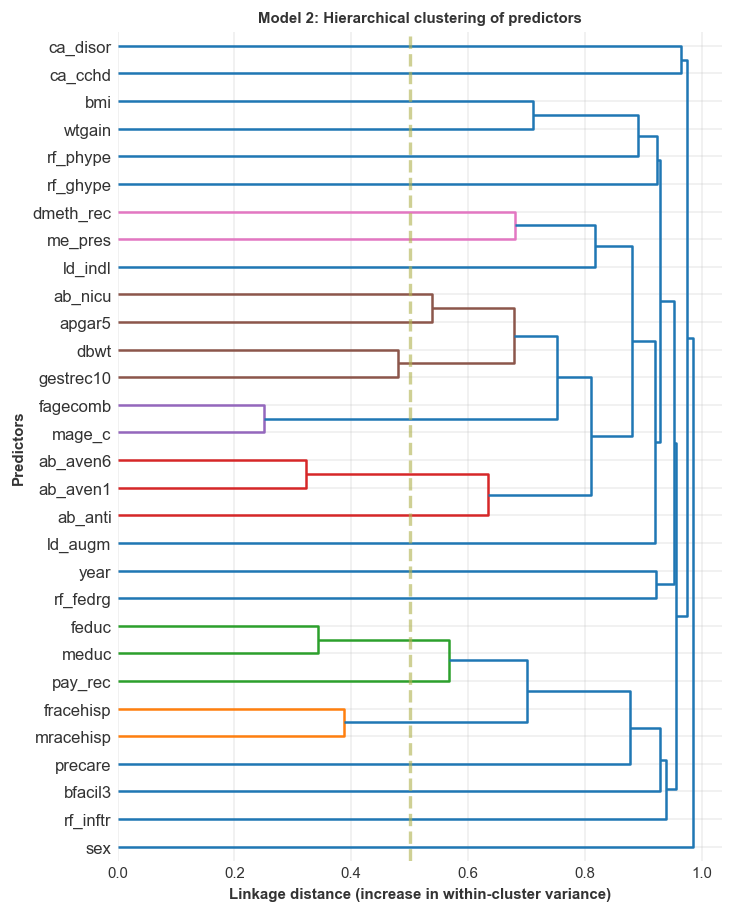

In [54]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

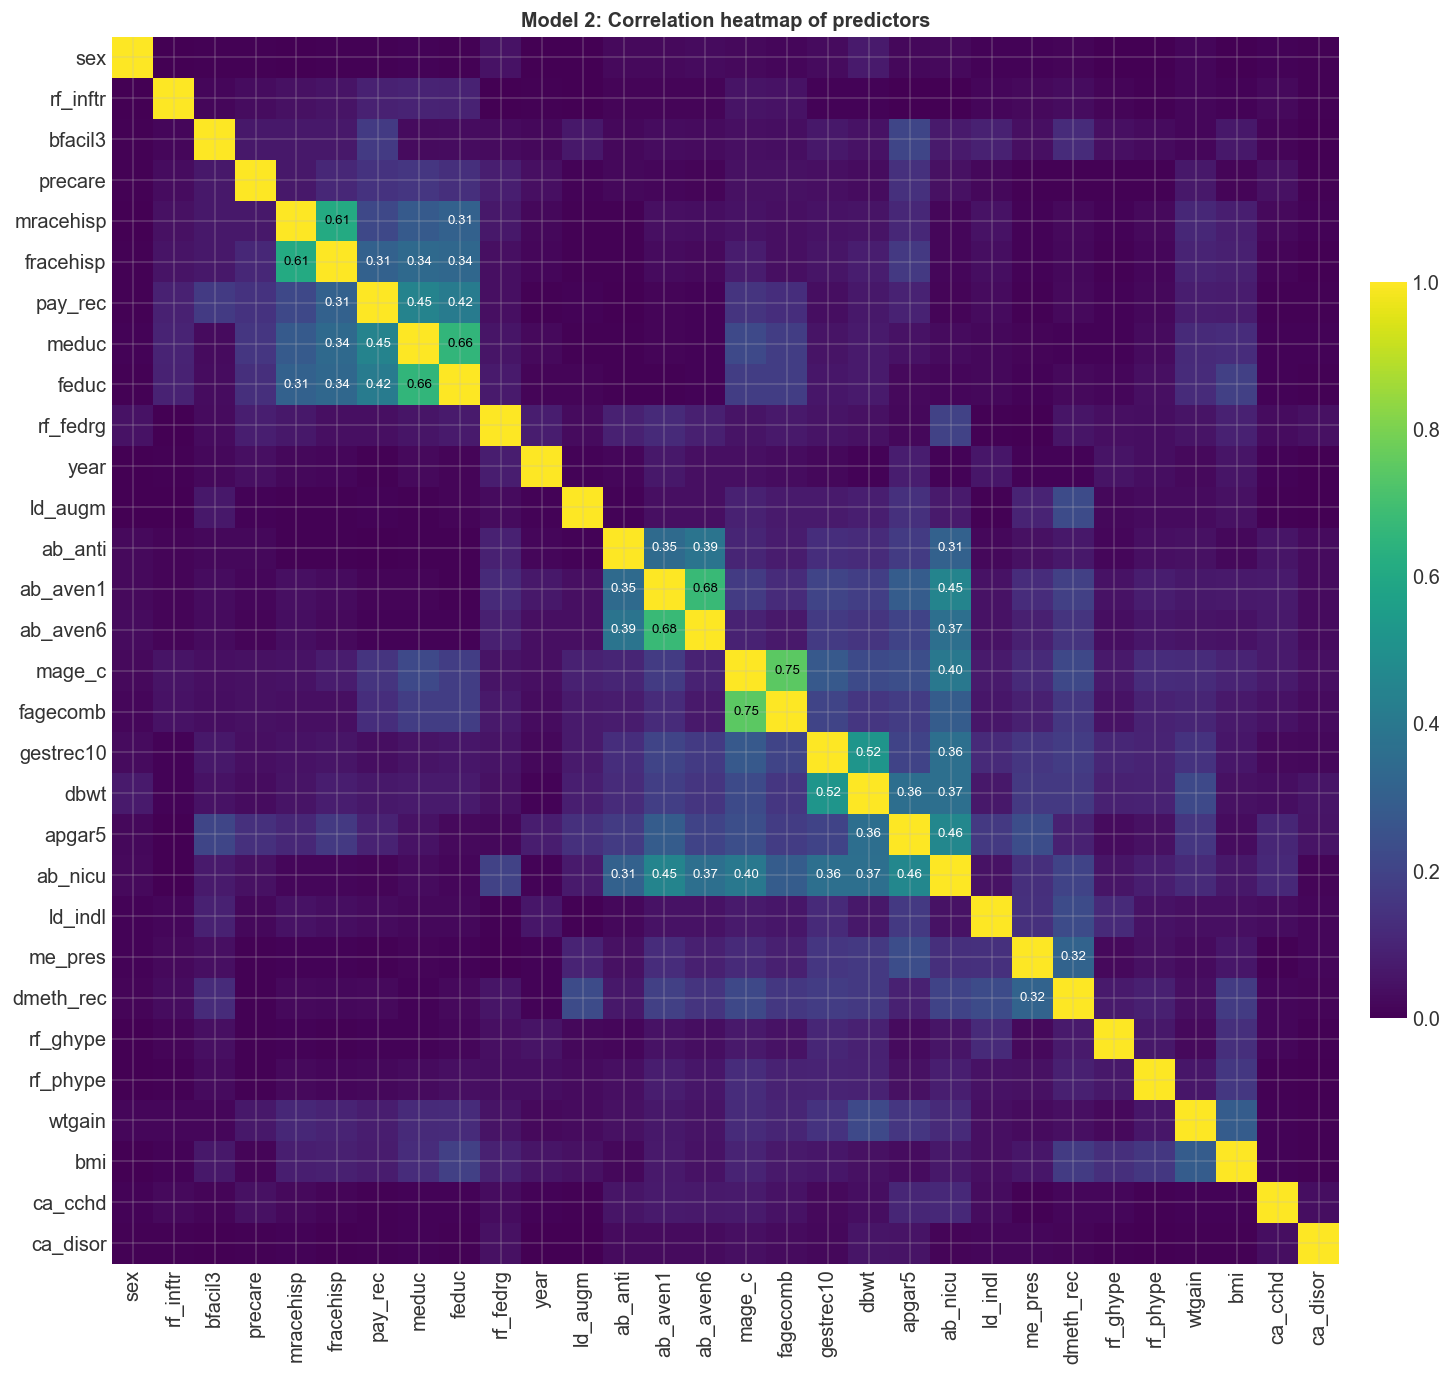

In [55]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [56]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\

feature  mean_abs_shap
15    ab_nicu       0.943176
28     mage_c       0.732896
25       dbwt       0.353874
3   gestrec10       0.299044
13   ab_aven1       0.214596
20  mracehisp       0.121683
26     wtgain       0.087355
17    ca_cchd       0.086084
18   ca_disor       0.073741
11  dmeth_rec       0.061215
24       year       0.059619
19      meduc       0.057630
14   ab_aven6       0.046038
5    rf_ghype       0.045501
2     precare       0.044563
29   fagecomb       0.042661
22  fracehisp       0.041727
27        bmi       0.038444
10    me_pres       0.035406
21      feduc       0.035364
16    ab_anti       0.033242
0     bfacil3       0.026620
23    pay_rec       0.019054
6    rf_inftr       0.016950
4    rf_phype       0.011051
7    rf_fedrg       0.010980
1         sex       0.008389
12     apgar5       0.007451
9     ld_augm       0.005800
8     ld_indl       0.003749

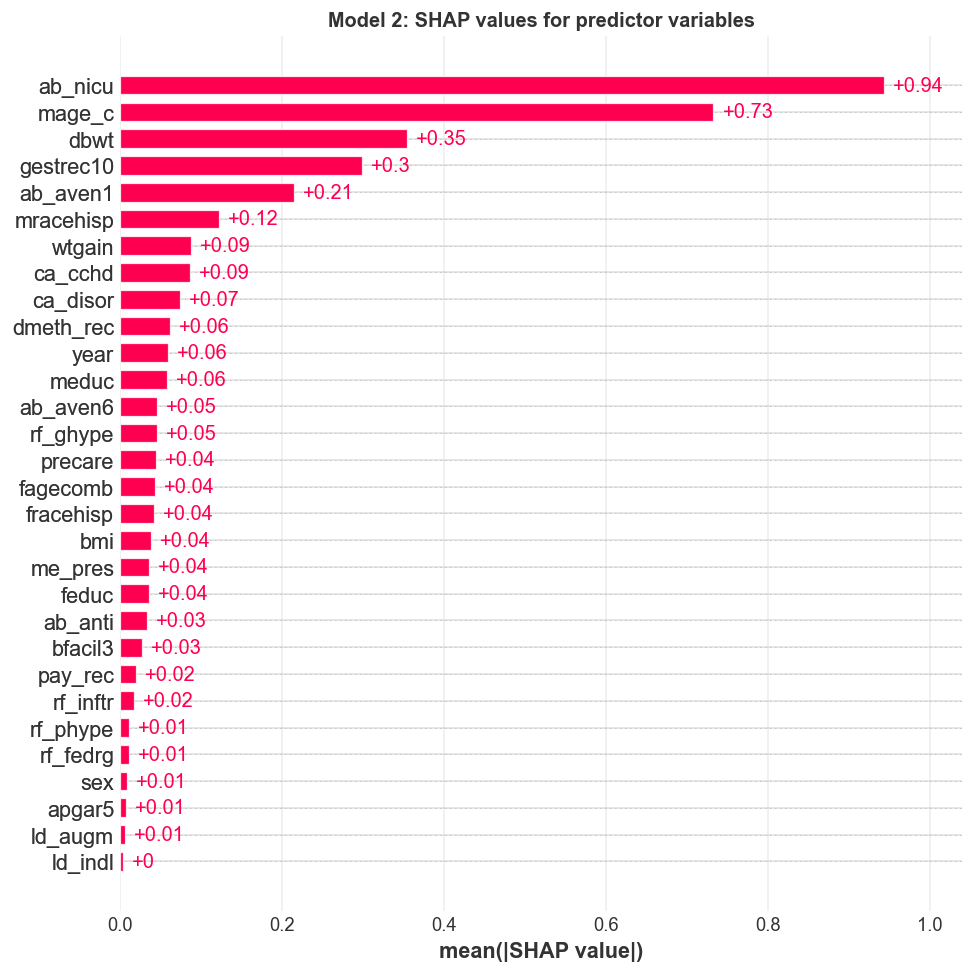

<Figure size 492x348 with 0 Axes>

In [57]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

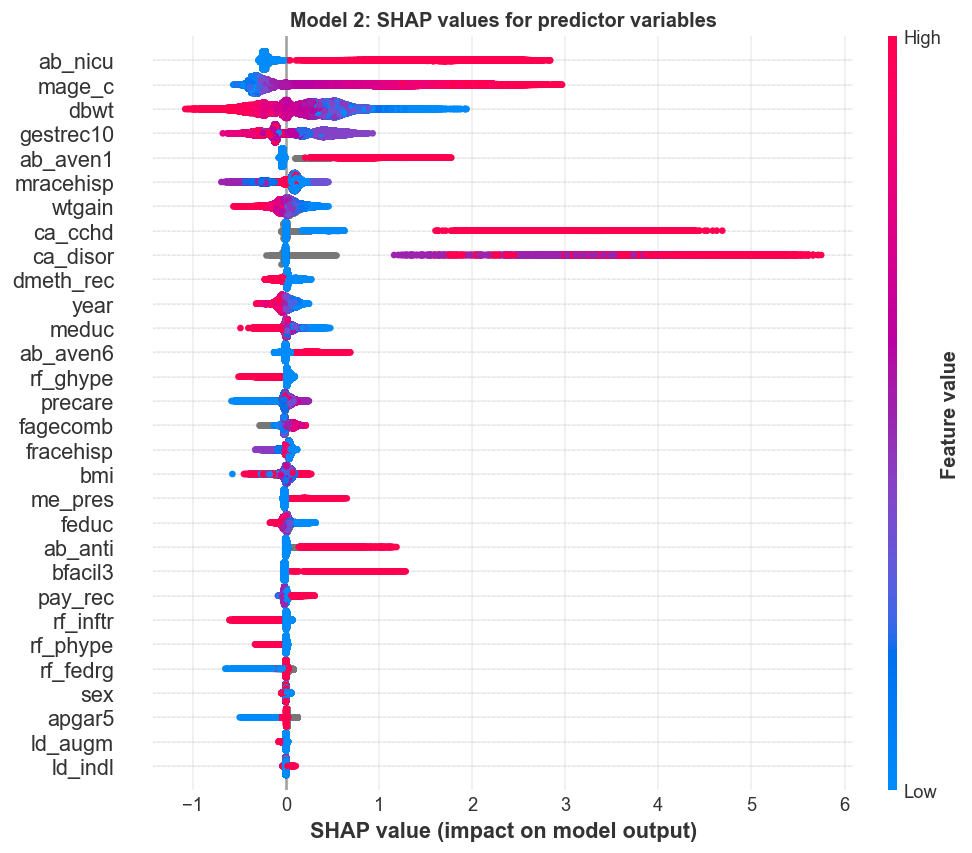

<Figure size 492x348 with 0 Axes>

In [58]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

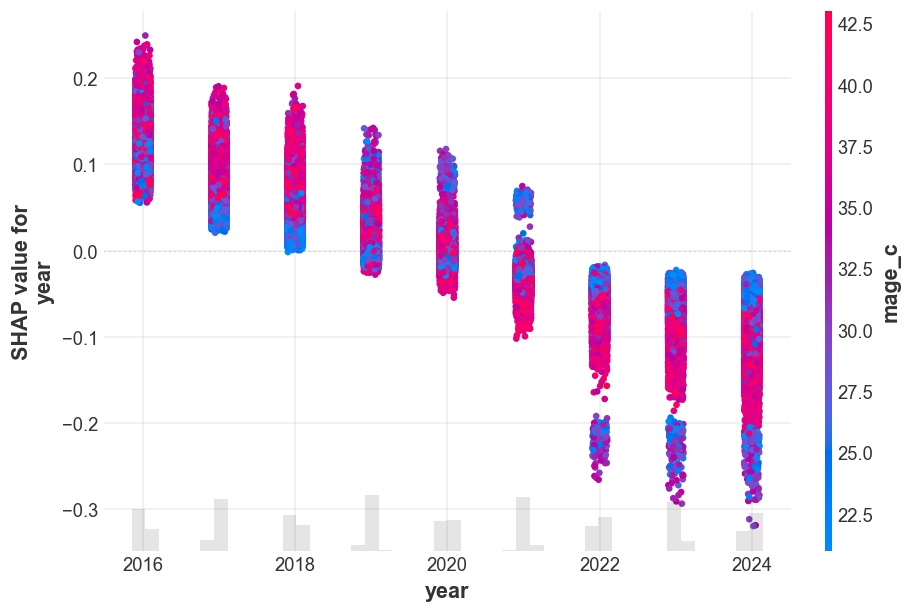

<Figure size 492x348 with 0 Axes>

In [59]:
ax = shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

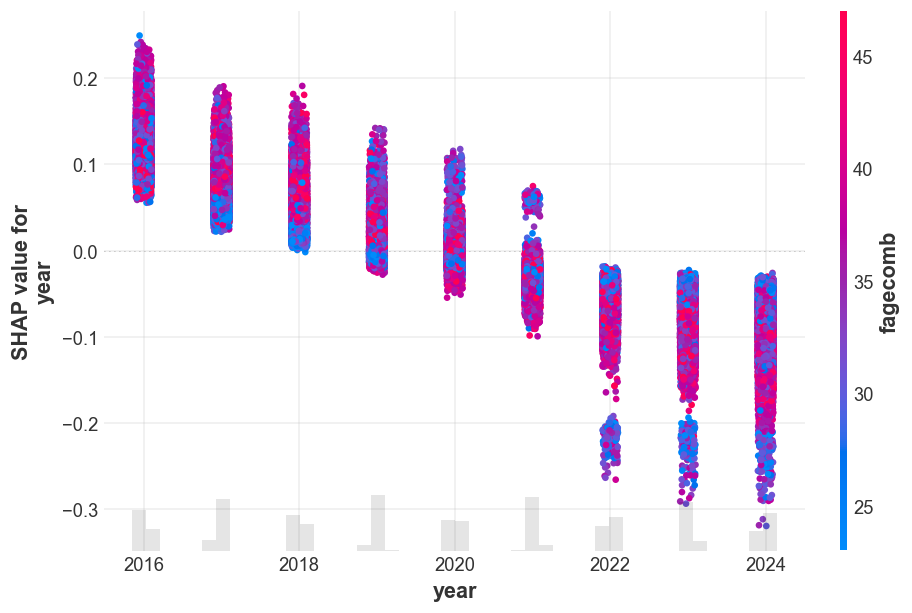

<Figure size 492x348 with 0 Axes>

In [75]:
ax = shap.plots.scatter(explanation[:, "year"], color=explanation[:, "fagecomb"])
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_paternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_paternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

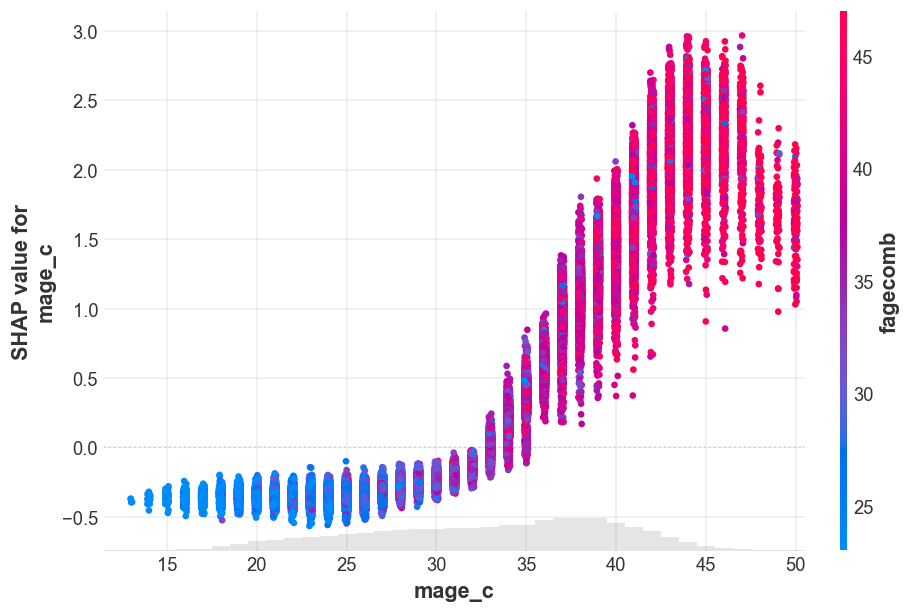

<Figure size 492x348 with 0 Axes>

In [79]:
ax = shap.plots.scatter(explanation[:, "mage_c"], color=explanation[:, "fagecomb"])
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_maternal_age_vs_paternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_maternal_age_vs_paternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

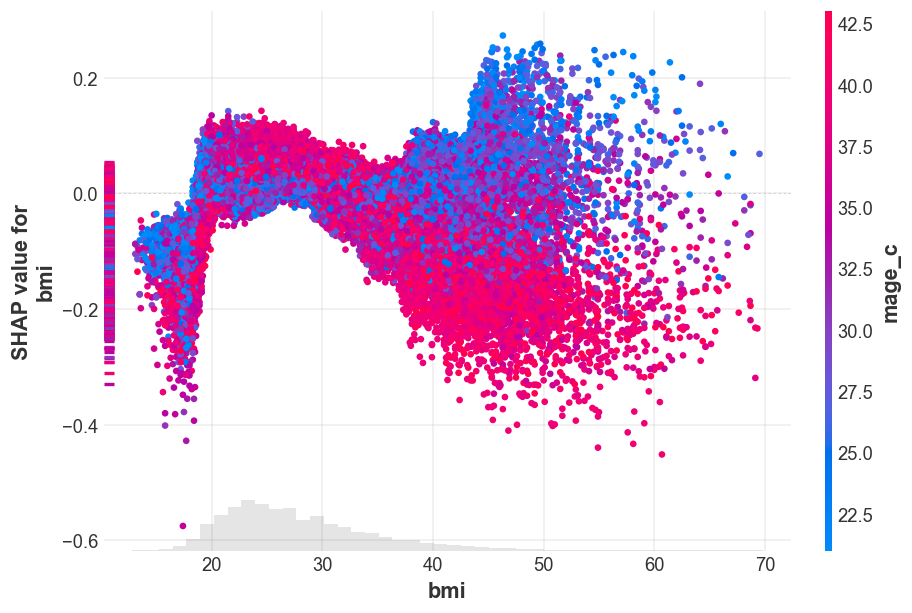

In [80]:
ax = shap.plots.scatter(explanation[:, "bmi"], color=explanation[:, "mage_c"])
plt.show()

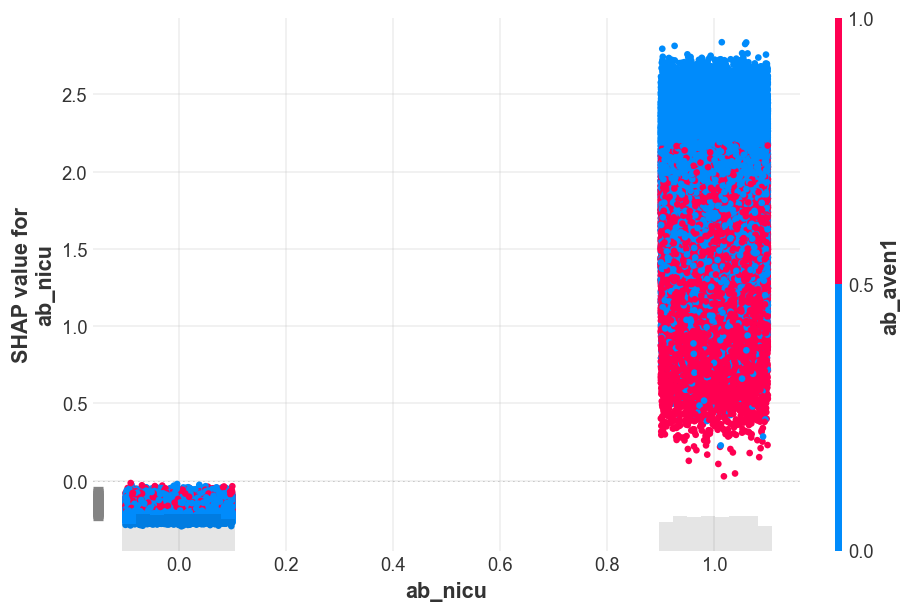

In [82]:
ax = shap.plots.scatter(explanation[:, "ab_nicu"], color=explanation[:, "ab_aven1"])
plt.show()

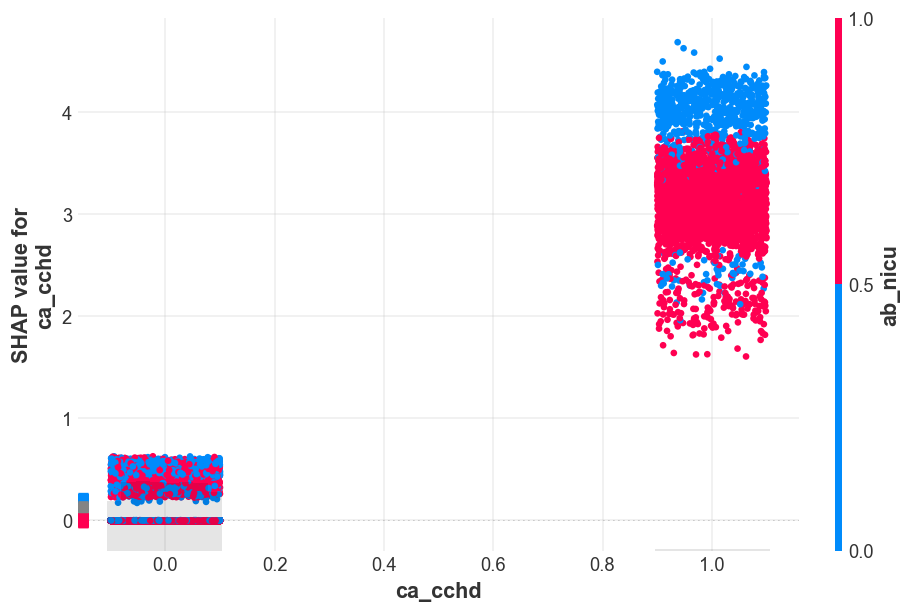

In [83]:
ax = shap.plots.scatter(explanation[:, "ca_cchd"], color=explanation[:, "ab_nicu"])
plt.show()

## Prediction


In [61]:
p_valid = gbm.predict(X_valid, num_iteration=gbm.best_iteration, raw_score=False)

print("best_iteration:", gbm.best_iteration)
print("mean raw prob:", float(p_valid.mean()))


print("Raw logloss:", log_loss(y_valid, p_valid, labels=[0, 1]))
print("Raw brier:  ", brier_score_loss(y_valid, p_valid))

best_iteration: 592
mean raw prob: 0.0005300263079342304
Raw logloss: 0.0036060219804723683
Raw brier:   0.0005214224069478635


In [62]:
def tail_calibration_table(y, p, fracs=(1e-2, 1e-3, 1e-4, 1e-5)):
    """
    Compare predicted vs observed event rates in the top fracs of scores.

    Parameters
    ----------
    y : array-like (0/1)
    p : array-like (probabilities)
    fracs : iterable of floats
        Fractions like 1e-3 for top 0.1%.

    Returns
    -------
    DataFrame with k, predicted mean, observed rate, and counts.
    """
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)

    order = np.argsort(-p)
    y_sorted = y[order]
    p_sorted = p[order]

    N = len(y)
    rows = []
    for f in fracs:
        k = max(1, int(round(N * f)))
        y_top = y_sorted[:k]
        p_top = p_sorted[:k]

        obs_rate = y_top.mean()
        pred_rate = p_top.mean()

        tp = int(y_top.sum())
        fp = int(k - tp)

        rows.append(
            {
                "top_frac": f,
                "k": k,
                "pred_rate_mean": pred_rate,
                "obs_rate": obs_rate,
                "tp": tp,
                "fp": fp,
                "pred_minus_obs": pred_rate - obs_rate,
                "ratio_pred_to_obs": (pred_rate / obs_rate) if obs_rate > 0 else np.nan,
            }
        )

    return pd.DataFrame(rows)

In [63]:
fracs = (1e-2, 1e-3, 1e-4, 1e-5)  # 1%, 0.1%, 0.01%, 0.001%

calibration_table = tail_calibration_table(y_valid, p_valid, fracs=fracs)

calibration_table["model"] = "raw"

calibration_table.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_tail_calibration_table.csv",
    index=False,
)

calibration_table

top_frac      k  pred_rate_mean  obs_rate    tp     fp  pred_minus_obs  \
0   0.01000  83973        0.017882  0.018518  1555  82418       -0.000636   
1   0.00100   8397        0.072644  0.072169   606   7791        0.000475   
2   0.00010    840        0.233946  0.192857   162    678        0.041089   
3   0.00001     84        0.452903  0.297619    25     59        0.155284   

   ratio_pred_to_obs model  
0           0.965658   raw  
1           1.006582   raw  
2           1.213052   raw  
3           1.521753   raw

In [64]:
gbm.save_model(
    f"{OUTPUT_DIR}/final_model_{model_idx}.txt",
    num_iteration=best_iter,
)

In [65]:
X_full = df[features]

categorical = [col for col in categorical if col in X_full.columns]

X_full[categorical] = X_full[categorical].astype("category")

In [66]:
p_full = gbm.predict(X_full, num_iteration=gbm.best_iteration)  # P(S=1|X)

In [67]:
df["p_ds_lb_pred_01"] = p_full

In [68]:
df[["year", "p_ds_lb_pred_01", "ca_down_c_p_n"]].groupby(
    "year"
).sum().reset_index()

year  p_ds_lb_pred_01  ca_down_c_p_n
0  2016      2104.349963           2168
1  2017      2032.798927           2044
2  2018      2049.913415           2108
3  2019      2021.140399           2030
4  2020      1949.712824           1954
5  2021      1944.375408           1903
6  2022      1891.338618           1861
7  2023      1899.272750           1855
8  2024      1908.441722           1886

In [69]:
import duckdb

con = duckdb.connect("./data/us_births.db")

In [70]:
con.execute(
    """
    ALTER TABLE us_births ADD COLUMN IF NOT EXISTS p_ds_lb_pred_01 DOUBLE;
    """
)
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")
con.execute(f"CREATE TABLE ds_lb_pred_01 (id BIGINT, p_ds_lb_pred DOUBLE)")

In [71]:
con.execute(
    """
    INSERT INTO ds_lb_pred_01 (id, p_ds_lb_pred)
    SELECT id, p_ds_lb_pred_01
    FROM df
    """
)

In [72]:
con.execute(
    """
    UPDATE us_births b
    SET p_ds_lb_pred_01 = p.p_ds_lb_pred
    FROM ds_lb_pred_01 p
    WHERE b.id = p.id;
    """
)

In [73]:
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")

In [74]:
con.close()